In [1]:
#inputdir = "/kaggle/input/ufo-sightings/"
#outdir = "/kaggle/working"
inputdir = "./ufo_in"
outdir = "./ufo_out"
!ls {inputdir}
!mkdir -p {outdir}

scrubbed.csv


In [2]:
%%time

#%pip install maptiles ggshow
#%conda install -c conda-forge r-base
#!Rscript -e "install.packages('ggplot2', repos='https://cloud.r-project.org/')"

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.72 µs


In [3]:
import os
import re
import sys
import random
from datetime import datetime, timedelta
from io import StringIO
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import DBSCAN
import statsmodels.api as sm
from tqdm import tqdm
import pyproj
import geopandas as gpd
import folium
from maptiles import draw_map
from ggshow import ggshow
%matplotlib inline

/Users/km255052/venv/sandbox/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [4]:
# we will be using the scrubbed data because the complete data contains varying number of columns per row
# and some error-like rows
# The file is downloaded from kaggle page: https://www.kaggle.com/NUFORC/ufo-sightings
tmp = pd.read_csv(os.path.join(inputdir, "scrubbed.csv"))
tmp = tmp.rename(columns={
     "duration (seconds)":"duration_sec"
    ,"duration (hours/min)":"duration_word"
    ,"date posted":"date_posted"
})
tmp.columns = tmp.columns.str.strip().str.lower()
print(tmp.dtypes)
tmp.head()

datetime          object
city              object
state             object
country           object
shape             object
duration_sec      object
duration_word     object
comments          object
date_posted       object
latitude          object
longitude        float64
dtype: object


/Users/km255052/venv/sandbox/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (5,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


datetime                  city state country     shape  \
0  10/10/1949 20:30            san marcos    tx      us  cylinder   
1  10/10/1949 21:00          lackland afb    tx     NaN     light   
2  10/10/1955 17:00  chester (uk/england)   NaN      gb    circle   
3  10/10/1956 21:00                  edna    tx      us    circle   
4  10/10/1960 20:00               kaneohe    hi      us     light   

  duration_sec duration_word  \
0         2700    45 minutes   
1         7200       1-2 hrs   
2           20    20 seconds   
3           20      1/2 hour   
4          900    15 minutes   

                                            comments date_posted    latitude  \
0  This event took place in early fall around 194...   4/27/2004  29.8830556   
1  1949 Lackland AFB&#44 TX.  Lights racing acros...  12/16/2005    29.38421   
2  Green/Orange circular disc over Chester&#44 En...   1/21/2008        53.2   
3  My older brother and twin sister were leaving ...   1/17/2004  28.9783333   
4  AS a Marine 1st Lt. flying an FJ4B fighter/att...   1/22/2004  21.4180556   

    longitude  
0  -97.941111  
1  -98.581082  
2   -2.916667  
3  -96.645833  
4 -157.803611

In [5]:
# data cleaning
def _to_datetime(d):
    r = re.search(r"^(\d{1,2})/(\d{1,2})/(\d{4}) (\d{1,2}):(\d{1,2})$", d.strip())
    if r is None:
        print("Unexpected datetime format '{}'".format(d), file=sys.stderr)
    day = datetime(int(r.group(3)), int(r.group(1)), int(r.group(2)))
    time = timedelta(hours=int(r.group(4)), minutes=int(r.group(5)))
    return day + time

def _to_date(d):
    r = re.search(r"^(\d{1,2})/(\d{1,2})/(\d{4})$", d.strip())
    if r is None:
        print("Unexpected date format '{}'".format(d), file=sys.stderr)
    day = datetime(int(r.group(3)), int(r.group(1)), int(r.group(2)))
    return day

x = tmp.copy()

x.datetime = tmp.datetime.apply(_to_datetime)
x.date_posted = tmp.date_posted.apply(_to_date)

x.duration_sec = tmp.duration_sec.astype(str).str.replace("`", "").astype(float)
x.latitude = tmp.latitude.astype(str).str.replace("q", "", regex=False).astype(float)

In [6]:
# check if we have generated extra missing values
pd.concat((tmp.isna().sum(), x.isna().sum()), axis=1)

0     1
datetime          0     0
city              0     0
state          5797  5797
country        9670  9670
shape          1932  1932
duration_sec      0     0
duration_word     0     0
comments         15    15
date_posted       0     0
latitude          0     0
longitude         0     0

In [7]:
# create web-mercator projected coordinates
t = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
tmp = [t.transform(lon, lat) for lon,lat in zip(x.longitude, x.latitude)]
x["longitude_proj"] = [a for a,b in tmp]
x["latitude_proj"] = [b for a,b in tmp]
x.head()

datetime                  city state country     shape  \
0 1949-10-10 20:30:00            san marcos    tx      us  cylinder   
1 1949-10-10 21:00:00          lackland afb    tx     NaN     light   
2 1955-10-10 17:00:00  chester (uk/england)   NaN      gb    circle   
3 1956-10-10 21:00:00                  edna    tx      us    circle   
4 1960-10-10 20:00:00               kaneohe    hi      us     light   

   duration_sec duration_word  \
0        2700.0    45 minutes   
1        7200.0       1-2 hrs   
2          20.0    20 seconds   
3          20.0      1/2 hour   
4         900.0    15 minutes   

                                            comments date_posted   latitude  \
0  This event took place in early fall around 194...  2004-04-27  29.883056   
1  1949 Lackland AFB&#44 TX.  Lights racing acros...  2005-12-16  29.384210   
2  Green/Orange circular disc over Chester&#44 En...  2008-01-21  53.200000   
3  My older brother and twin sister were leaving ...  2004-01-17  28.978333   
4  AS a Marine 1st Lt. flying an FJ4B fighter/att...  2004-01-22  21.418056   

    longitude  longitude_proj  latitude_proj  
0  -97.941111   -1.090275e+07   3.488527e+06  
1  -98.581082   -1.097400e+07   3.424639e+06  
2   -2.916667   -3.246819e+05   7.020079e+06  
3  -96.645833   -1.075856e+07   3.372889e+06  
4 -157.803611   -1.756662e+07   2.441798e+06

In [8]:
x = gpd.GeoDataFrame(x, geometry=gpd.points_from_xy(x.longitude, x.latitude), crs="EPSG:4326")
x.head()

datetime                  city state country     shape  \
0 1949-10-10 20:30:00            san marcos    tx      us  cylinder   
1 1949-10-10 21:00:00          lackland afb    tx     NaN     light   
2 1955-10-10 17:00:00  chester (uk/england)   NaN      gb    circle   
3 1956-10-10 21:00:00                  edna    tx      us    circle   
4 1960-10-10 20:00:00               kaneohe    hi      us     light   

   duration_sec duration_word  \
0        2700.0    45 minutes   
1        7200.0       1-2 hrs   
2          20.0    20 seconds   
3          20.0      1/2 hour   
4         900.0    15 minutes   

                                            comments date_posted   latitude  \
0  This event took place in early fall around 194...  2004-04-27  29.883056   
1  1949 Lackland AFB&#44 TX.  Lights racing acros...  2005-12-16  29.384210   
2  Green/Orange circular disc over Chester&#44 En...  2008-01-21  53.200000   
3  My older brother and twin sister were leaving ...  2004-01-17  28.978333   
4  AS a Marine 1st Lt. flying an FJ4B fighter/att...  2004-01-22  21.418056   

    longitude  longitude_proj  latitude_proj                     geometry  
0  -97.941111   -1.090275e+07   3.488527e+06   POINT (-97.94111 29.88306)  
1  -98.581082   -1.097400e+07   3.424639e+06   POINT (-98.58108 29.38421)  
2   -2.916667   -3.246819e+05   7.020079e+06    POINT (-2.91667 53.20000)  
3  -96.645833   -1.075856e+07   3.372889e+06   POINT (-96.64583 28.97833)  
4 -157.803611   -1.756662e+07   2.441798e+06  POINT (-157.80361 21.41806)

In [9]:
x.describe(datetime_is_numeric=True)

datetime  duration_sec  \
count                          80332  8.033200e+04   
mean   2004-05-17 04:07:35.261166336  9.016889e+03   
min              1906-11-11 00:00:00  1.000000e-03   
25%              2001-08-02 21:45:00  3.000000e+01   
50%              2006-11-22 04:05:00  1.800000e+02   
75%              2011-06-21 00:30:00  6.000000e+02   
max              2014-05-08 18:45:00  9.783600e+07   
std                              NaN  6.202168e+05   

                         date_posted      latitude     longitude  \
count                          80332  80332.000000  80332.000000   
mean   2007-07-28 02:15:17.074142464     38.124416    -86.772885   
min              1998-03-07 00:00:00    -82.862752   -176.658056   
25%              2003-11-26 00:00:00     34.134722   -112.073333   
50%              2007-11-28 00:00:00     39.411111    -87.903611   
75%              2011-10-10 00:00:00     42.788333    -78.755000   
max              2014-05-08 00:00:00     72.700000    178.441900   
std                              NaN     10.469585     39.697205   

       longitude_proj  latitude_proj  
count    8.033200e+04   8.033200e+04  
mean    -9.659513e+06   4.665483e+06  
min     -1.966548e+07  -1.769775e+07  
25%     -1.247595e+07   4.046906e+06  
50%     -9.785385e+06   4.780732e+06  
75%     -8.766966e+06   5.279809e+06  
max      1.986406e+07   1.201022e+07  
std      4.419073e+06   1.383039e+06

In [10]:
# US county borders
!wget https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_county_20m.zip
!unzip -o cb_2018_us_county_20m.zip
cb = gpd.read_file("cb_2018_us_county_20m.shp").to_crs("EPSG:4326")
display(cb)

x = x.sjoin(cb, how="left", predicate="intersects")
x

--2022-05-14 21:40:23--  https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_county_20m.zip
Resolving www2.census.gov (www2.census.gov)... 2600:1409:3000:39a::208c, 2600:1409:3000:39e::208c, 104.124.136.170
Connecting to www2.census.gov (www2.census.gov)|2600:1409:3000:39a::208c|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘cb_2018_us_county_20m.zip.4’

cb_2018_us_county_2     [     <=>            ] 844.28K  1015KB/s    in 0.8s    

2022-05-14 21:40:25 (1015 KB/s) - ‘cb_2018_us_county_20m.zip.4’ saved [864539]

Archive:  cb_2018_us_county_20m.zip
  inflating: cb_2018_us_county_20m.shp.ea.iso.xml  
  inflating: cb_2018_us_county_20m.shp.iso.xml  
  inflating: cb_2018_us_county_20m.shp  
  inflating: cb_2018_us_county_20m.shx  
  inflating: cb_2018_us_county_20m.dbf  
  inflating: cb_2018_us_county_20m.prj  
 extracting: cb_2018_us_county_20m.cpg  


STATEFP COUNTYFP  COUNTYNS        AFFGEOID  GEOID      NAME LSAD  \
0         37      017  01026336  0500000US37017  37017    Bladen   06   
1         37      167  01025844  0500000US37167  37167    Stanly   06   
2         39      153  01074088  0500000US39153  39153    Summit   06   
3         42      113  01213687  0500000US42113  42113  Sullivan   06   
4         48      459  01384015  0500000US48459  48459    Upshur   06   
...      ...      ...       ...             ...    ...       ...  ...   
3215      38      005  01034216  0500000US38005  38005    Benson   06   
3216      72      079  01804520  0500000US72079  72079     Lajas   13   
3217      31      159  00835901  0500000US31159  31159    Seward   06   
3218      37      023  01008539  0500000US37023  37023     Burke   06   
3219      13      261  00343504  0500000US13261  13261    Sumter   06   

           ALAND     AWATER                                           geometry  
0     2265887723   33010866  POLYGON ((-78.90200 34.83527, -78.79960 34.850...  
1     1023370459   25242751  POLYGON ((-80.49737 35.20210, -80.29542 35.502...  
2     1069181981   18958267  POLYGON ((-81.68699 41.13596, -81.68495 41.277...  
3     1165338428    6617028  POLYGON ((-76.81373 41.59003, -76.22014 41.541...  
4     1509910100   24878888  POLYGON ((-95.15274 32.66095, -95.15211 32.902...  
...          ...        ...                                                ...  
3215  3596569006  131708143  POLYGON ((-99.84661 48.37130, -99.49292 48.370...  
3216   155287827  106643202  POLYGON ((-67.10904 18.05608, -67.06791 18.066...  
3217  1479995670   11542537  POLYGON ((-97.36812 41.04695, -96.91094 41.046...  
3218  1311146878   20719896  POLYGON ((-81.90665 35.88338, -81.94319 35.960...  
3219  1250630094   25227638  POLYGON ((-84.43301 32.04196, -84.43121 32.134...  

[3220 rows x 10 columns]

datetime                  city state country     shape  \
0     1949-10-10 20:30:00            san marcos    tx      us  cylinder   
1     1949-10-10 21:00:00          lackland afb    tx     NaN     light   
2     1955-10-10 17:00:00  chester (uk/england)   NaN      gb    circle   
3     1956-10-10 21:00:00                  edna    tx      us    circle   
4     1960-10-10 20:00:00               kaneohe    hi      us     light   
...                   ...                   ...   ...     ...       ...   
80327 2013-09-09 21:15:00             nashville    tn      us     light   
80328 2013-09-09 22:00:00                 boise    id      us    circle   
80329 2013-09-09 22:00:00                  napa    ca      us     other   
80330 2013-09-09 22:20:00                vienna    va      us    circle   
80331 2013-09-09 23:00:00                edmond    ok      us     cigar   

       duration_sec duration_word  \
0            2700.0    45 minutes   
1            7200.0       1-2 hrs   
2              20.0    20 seconds   
3              20.0      1/2 hour   
4             900.0    15 minutes   
...             ...           ...   
80327         600.0    10 minutes   
80328        1200.0    20 minutes   
80329        1200.0          hour   
80330           5.0     5 seconds   
80331        1020.0    17 minutes   

                                                comments date_posted  \
0      This event took place in early fall around 194...  2004-04-27   
1      1949 Lackland AFB&#44 TX.  Lights racing acros...  2005-12-16   
2      Green/Orange circular disc over Chester&#44 En...  2008-01-21   
3      My older brother and twin sister were leaving ...  2004-01-17   
4      AS a Marine 1st Lt. flying an FJ4B fighter/att...  2004-01-22   
...                                                  ...         ...   
80327  Round from the distance/slowly changing colors...  2013-09-30   
80328  Boise&#44 ID&#44 spherical&#44 20 min&#44 10 r...  2013-09-30   
80329                                       Napa UFO&#44  2013-09-30   
80330  Saw a five gold lit cicular craft moving fastl...  2013-09-30   
80331  2 witnesses 2  miles apart&#44 Red &amp; White...  2013-09-30   

        latitude  ...  index_right  STATEFP  COUNTYFP  COUNTYNS  \
0      29.883056  ...       1178.0       48       209  01383890   
1      29.384210  ...       1409.0       48       029  01383800   
2      53.200000  ...          NaN      NaN       NaN       NaN   
3      28.978333  ...       3005.0       48       239  01383905   
4      21.418056  ...       1166.0       15       003  00365281   
...          ...  ...          ...      ...       ...       ...   
80327  36.165833  ...       1036.0       47       037  01639737   
80328  43.613611  ...        420.0       16       001  00395066   
80329  38.297222  ...        535.0       06       055  00277292   
80330  38.901111  ...       1991.0       51       059  01480119   
80331  35.652778  ...        854.0       40       109  01101842   

             AFFGEOID  GEOID      NAME LSAD         ALAND        AWATER  
0      0500000US48209  48209      Hays   06  1.755979e+09  5.037743e+06  
1      0500000US48029  48029     Bexar   06  3.212141e+09  4.107971e+07  
2                 NaN    NaN       NaN  NaN           NaN           NaN  
3      0500000US48239  48239   Jackson   06  2.148247e+09  7.103957e+07  
4      0500000US15003  15003  Honolulu   06  1.555454e+09  4.055036e+09  
...               ...    ...       ...  ...           ...           ...  
80327  0500000US47037  47037  Davidson   06  1.304033e+09  5.659044e+07  
80328  0500000US16001  16001       Ada   06  2.724688e+09  2.217618e+07  
80329  0500000US06055  06055      Napa   06  1.938114e+09  1.043008e+08  
80330  0500000US51059  51059   Fairfax   06  1.012684e+09  4.012692e+07  
80331  0500000US40109  40109  Oklahoma   06  1.835846e+09  2.473059e+07  

[80332 rows x 24 columns]

In [11]:
# state information
#   FIPS code: https://www.nrcs.usda.gov/wps/portal/nrcs/detail/?cid=nrcs143_013696
#              https://www.mcc.co.mercer.pa.us/dps/state_fips_code_listing.htm
#   Population: https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_population
statefips = """
state_name	state_code	state_fips
Alabama 	AL 	01
Alaska 	AK 	02
Arizona 	AZ 	04
Arkansas 	AR 	05
California 	CA 	06
Colorado 	CO 	08
Connecticut 	CT 	09
Delaware 	DE 	10
District of Columbia	DC 	11
Florida 	FL 	12
Georgia 	GA 	13
Hawaii 	HI 	15
Idaho 	ID 	16
Illinois 	IL 	17
Indiana 	IN 	18
Iowa 	IA 	19
Kansas 	KS 	20
Kentucky 	KY 	21
Louisiana 	LA 	22
Maine 	ME 	23
Maryland 	MD 	24
Massachusetts 	MA 	25
Michigan 	MI 	26
Minnesota 	MN 	27
Mississippi 	MS 	28
Missouri 	MO 	29
Montana 	MT 	30
Nebraska 	NE 	31
Nevada 	NV 	32
New Hampshire 	NH 	33
New Jersey 	NJ 	34
New Mexico 	NM 	35
New York 	NY 	36
North Carolina 	NC 	37
North Dakota 	ND 	38
Ohio 	OH 	39
Oklahoma 	OK 	40
Oregon 	OR 	41
Pennsylvania 	PA 	42
Rhode Island 	RI 	44
South Carolina 	SC 	45
South Dakota 	SD 	46
Tennessee 	TN 	47
Texas 	TX 	48
Utah 	UT 	49
Vermont 	VT 	50
Virginia 	VA 	51
Washington 	WA 	53
West Virginia 	WV 	54
Wisconsin 	WI 	55
Wyoming 	WY 	56
American Samoa 	AS 	60
Guam 	GU 	66
Northern Mariana Islands 	MP 	69
Puerto Rico 	PR 	72
Virgin Islands 	VI 	78
"""
statefips = pd.read_csv(StringIO(statefips.strip()), sep="\t", dtype=str)
statefips.state_name = statefips.state_name.str.strip()
statefips.state_code = statefips.state_code.str.strip()

statepop = """
state_name	statepop2021	statepop2010
California	39237836	37253956
Texas	29527941	25145561
Florida	21781128	18801310
New York	19835913	19378102
Pennsylvania	12964056	12702379
Illinois	12671469	12830632
Ohio	11780017	11536504
Georgia	10799566	9687653
North Carolina	10551162	9535483
Michigan	10050811	9883640
New Jersey	9267130	8791894
Virginia	8642274	8001024
Washington	7738692	6724540
Arizona	7276316	6392017
Massachusetts	6984723	6547629
Tennessee	6975218	6346105
Indiana	6805985	6483802
Maryland	6165129	5773552
Missouri	6168187	5988927
Wisconsin	5895908	5686986
Colorado	5812069	5029196
Minnesota	5707390	5303925
South Carolina	5190705	4625364
Alabama	5039877	4779736
Louisiana	4657757	4533372
Kentucky	4505836	4339367
Oregon	4237256	3831074
Oklahoma	3959353	3751351
Connecticut	3605944	3574097
Puerto Rico	3285874	3725789
Utah	3271616	2763885
Iowa	3190369	3046355
Nevada	3104614	2700551
Arkansas	3011524	2915918
Mississippi	2961279	2967297
Kansas	2937880	2853118
New Mexico	2117522	2059179
Nebraska	1961504	1826341
Idaho	1839106	1567582
West Virginia	1793716	1852994
Hawaii	1455271	1360301
New Hampshire	1377529	1316470
Maine	1362359	1328361
Rhode Island	1097379	1052567
Montana	1084225	989415
Delaware	989948	897934
South Dakota	886667	814180
North Dakota	779094	672591
Alaska	733391	710231
District of Columbia	689545	601723
Vermont	643077	625741
Wyoming	576851	563626
Guam	153836	159358
Virgin Islands	87146	106405
American Samoa	49710	55519
Northern Mariana Islands	47329	53883
"""
statepop = pd.read_csv(StringIO(statepop.strip()), sep="\t")

diff1 = set(statepop.state_name) - set(statefips.state_name)
diff2 = set(statefips.state_name) - set(statepop.state_name)
assert len(diff1) == 0, diff1
assert len(diff2) == 0, diff2

stateinfo = pd.merge(statefips, statepop, on="state_name")
display(stateinfo)

x = pd.merge(x, stateinfo, how="left", left_on="STATEFP", right_on="state_fips")
x

state_name state_code state_fips  statepop2021  statepop2010
0                    Alabama         AL         01       5039877       4779736
1                     Alaska         AK         02        733391        710231
2                    Arizona         AZ         04       7276316       6392017
3                   Arkansas         AR         05       3011524       2915918
4                 California         CA         06      39237836      37253956
5                   Colorado         CO         08       5812069       5029196
6                Connecticut         CT         09       3605944       3574097
7                   Delaware         DE         10        989948        897934
8       District of Columbia         DC         11        689545        601723
9                    Florida         FL         12      21781128      18801310
10                   Georgia         GA         13      10799566       9687653
11                    Hawaii         HI         15       1455271       1360301
12                     Idaho         ID         16       1839106       1567582
13                  Illinois         IL         17      12671469      12830632
14                   Indiana         IN         18       6805985       6483802
15                      Iowa         IA         19       3190369       3046355
16                    Kansas         KS         20       2937880       2853118
17                  Kentucky         KY         21       4505836       4339367
18                 Louisiana         LA         22       4657757       4533372
19                     Maine         ME         23       1362359       1328361
20                  Maryland         MD         24       6165129       5773552
21             Massachusetts         MA         25       6984723       6547629
22                  Michigan         MI         26      10050811       9883640
23                 Minnesota         MN         27       5707390       5303925
24               Mississippi         MS         28       2961279       2967297
25                  Missouri         MO         29       6168187       5988927
26                   Montana         MT         30       1084225        989415
27                  Nebraska         NE         31       1961504       1826341
28                    Nevada         NV         32       3104614       2700551
29             New Hampshire         NH         33       1377529       1316470
30                New Jersey         NJ         34       9267130       8791894
31                New Mexico         NM         35       2117522       2059179
32                  New York         NY         36      19835913      19378102
33            North Carolina         NC         37      10551162       9535483
34              North Dakota         ND         38        779094        672591
35                      Ohio         OH         39      11780017      11536504
36                  Oklahoma         OK         40       3959353       3751351
37                    Oregon         OR         41       4237256       3831074
38              Pennsylvania         PA         42      12964056      12702379
39              Rhode Island         RI         44       1097379       1052567
40            South Carolina         SC         45       5190705       4625364
41              South Dakota         SD         46        886667        814180
42                 Tennessee         TN         47       6975218       6346105
43                     Texas         TX         48      29527941      25145561
44                      Utah         UT         49       3271616       2763885
45                   Vermont         VT         50        643077        625741
46                  Virginia         VA         51       8642274       8001024
47                Washington         WA         53       7738692       6724540
48             West Virginia         WV         54       1793716       1852994
49                 Wisconsin         WI         55       5895908    

datetime                  city state country     shape  \
0     1949-10-10 20:30:00            san marcos    tx      us  cylinder   
1     1949-10-10 21:00:00          lackland afb    tx     NaN     light   
2     1955-10-10 17:00:00  chester (uk/england)   NaN      gb    circle   
3     1956-10-10 21:00:00                  edna    tx      us    circle   
4     1960-10-10 20:00:00               kaneohe    hi      us     light   
...                   ...                   ...   ...     ...       ...   
80327 2013-09-09 21:15:00             nashville    tn      us     light   
80328 2013-09-09 22:00:00                 boise    id      us    circle   
80329 2013-09-09 22:00:00                  napa    ca      us     other   
80330 2013-09-09 22:20:00                vienna    va      us    circle   
80331 2013-09-09 23:00:00                edmond    ok      us     cigar   

       duration_sec duration_word  \
0            2700.0    45 minutes   
1            7200.0       1-2 hrs   
2              20.0    20 seconds   
3              20.0      1/2 hour   
4             900.0    15 minutes   
...             ...           ...   
80327         600.0    10 minutes   
80328        1200.0    20 minutes   
80329        1200.0          hour   
80330           5.0     5 seconds   
80331        1020.0    17 minutes   

                                                comments date_posted  \
0      This event took place in early fall around 194...  2004-04-27   
1      1949 Lackland AFB&#44 TX.  Lights racing acros...  2005-12-16   
2      Green/Orange circular disc over Chester&#44 En...  2008-01-21   
3      My older brother and twin sister were leaving ...  2004-01-17   
4      AS a Marine 1st Lt. flying an FJ4B fighter/att...  2004-01-22   
...                                                  ...         ...   
80327  Round from the distance/slowly changing colors...  2013-09-30   
80328  Boise&#44 ID&#44 spherical&#44 20 min&#44 10 r...  2013-09-30   
80329                                       Napa UFO&#44  2013-09-30   
80330  Saw a five gold lit cicular craft moving fastl...  2013-09-30   
80331  2 witnesses 2  miles apart&#44 Red &amp; White...  2013-09-30   

        latitude  ...  GEOID      NAME  LSAD         ALAND        AWATER  \
0      29.883056  ...  48209      Hays    06  1.755979e+09  5.037743e+06   
1      29.384210  ...  48029     Bexar    06  3.212141e+09  4.107971e+07   
2      53.200000  ...    NaN       NaN   NaN           NaN           NaN   
3      28.978333  ...  48239   Jackson    06  2.148247e+09  7.103957e+07   
4      21.418056  ...  15003  Honolulu    06  1.555454e+09  4.055036e+09   
...          ...  ...    ...       ...   ...           ...           ...   
80327  36.165833  ...  47037  Davidson    06  1.304033e+09  5.659044e+07   
80328  43.613611  ...  16001       Ada    06  2.724688e+09  2.217618e+07   
80329  38.297222  ...  06055      Napa    06  1.938114e+09  1.043008e+08   
80330  38.901111  ...  51059   Fairfax    06  1.012684e+09  4.012692e+07   
80331  35.652778  ...  40109  Oklahoma    06  1.835846e+09  2.473059e+07   

       state_name state_code state_fips statepop2021 statepop2010  
0           Texas         TX         48   29527941.0   25145561.0  
1           Texas         TX         48   29527941.0   25145561.0  
2             NaN        NaN        NaN          NaN          NaN  
3           Texas         TX         48   29527941.0   25145561.0  
4          Hawaii         HI         15    1455271.0    1360301.0  
...           ...        ...        ...          ...          ...  
80327   Tennessee         TN         47    6975218.0    6346105.0  
80328       Idaho         ID         16    1839106.0    1567582.0  
80329  California         CA         06   39237836.0   37253956.0  
80330    Virginia         VA         51    8642274.0    8001024.0  
80331    Oklahoma         OK         40    3959353.0    3751351.0  

[80332 rows x 29 columns]

In [12]:
# exploratory analysis
x["year2000p"] = (x.datetime.dt.year >= 2000)
x["usa"] = ~x.state_code.isna()

In [13]:
print("ratio of year2000+", x.year2000p.mean())

ratio of year2000+ 0.8069760493950107


In [14]:
# counts, US vs others
print("all period", x.usa.sum(), x.usa.mean())
print("year2000+", x[x.year2000p].usa.sum(), x[x.year2000p].usa.mean())

all period 70759 0.8808320470049296
year2000+ 56973 0.8788603338166785


In [15]:
# US state distribution

tmp = x.groupby(["state_code", "state_name"]).size().sort_values(ascending=False)
display(tmp)

tmp = x[x.datetime.dt.year >= 2000].groupby(["state_code", "state_name"]).size().sort_values(ascending=False)
display(tmp)

state_code  state_name          
CA          California              9609
WA          Washington              4265
FL          Florida                 4190
TX          Texas                   3689
NY          New York                3253
AZ          Arizona                 2703
IL          Illinois                2648
PA          Pennsylvania            2584
OH          Ohio                    2402
MI          Michigan                2049
NC          North Carolina          1866
OR          Oregon                  1848
MO          Missouri                1580
CO          Colorado                1516
NJ          New Jersey              1495
VA          Virginia                1418
IN          Indiana                 1373
MA          Massachusetts           1351
WI          Wisconsin               1318
GA          Georgia                 1317
TN          Tennessee               1175
MN          Minnesota               1088
SC          South Carolina          1081
CT          Connecticut 

state_code  state_name          
CA          California              7747
FL          Florida                 3573
WA          Washington              3306
TX          Texas                   2912
NY          New York                2526
AZ          Arizona                 2238
IL          Illinois                2172
PA          Pennsylvania            2105
OH          Ohio                    1871
MI          Michigan                1586
NC          North Carolina          1572
OR          Oregon                  1477
CO          Colorado                1244
MO          Missouri                1238
NJ          New Jersey              1205
VA          Virginia                1170
IN          Indiana                 1128
MA          Massachusetts           1103
GA          Georgia                 1075
WI          Wisconsin               1044
TN          Tennessee                956
SC          South Carolina           949
MN          Minnesota                893
CT          Connecticut 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


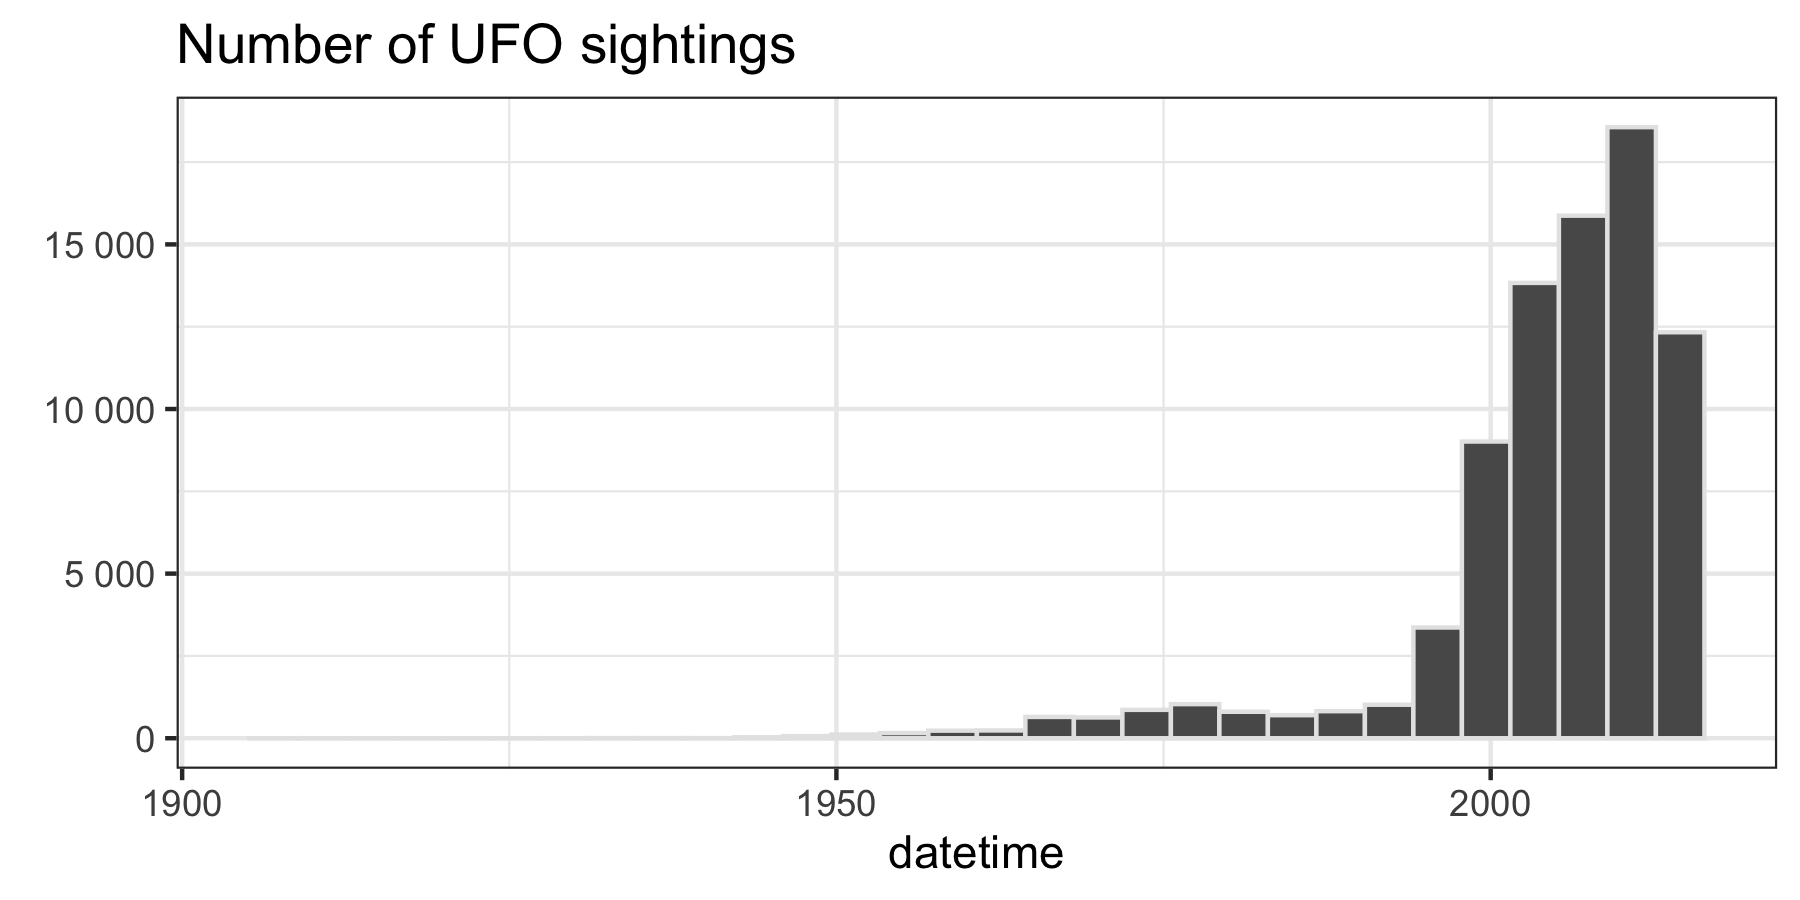

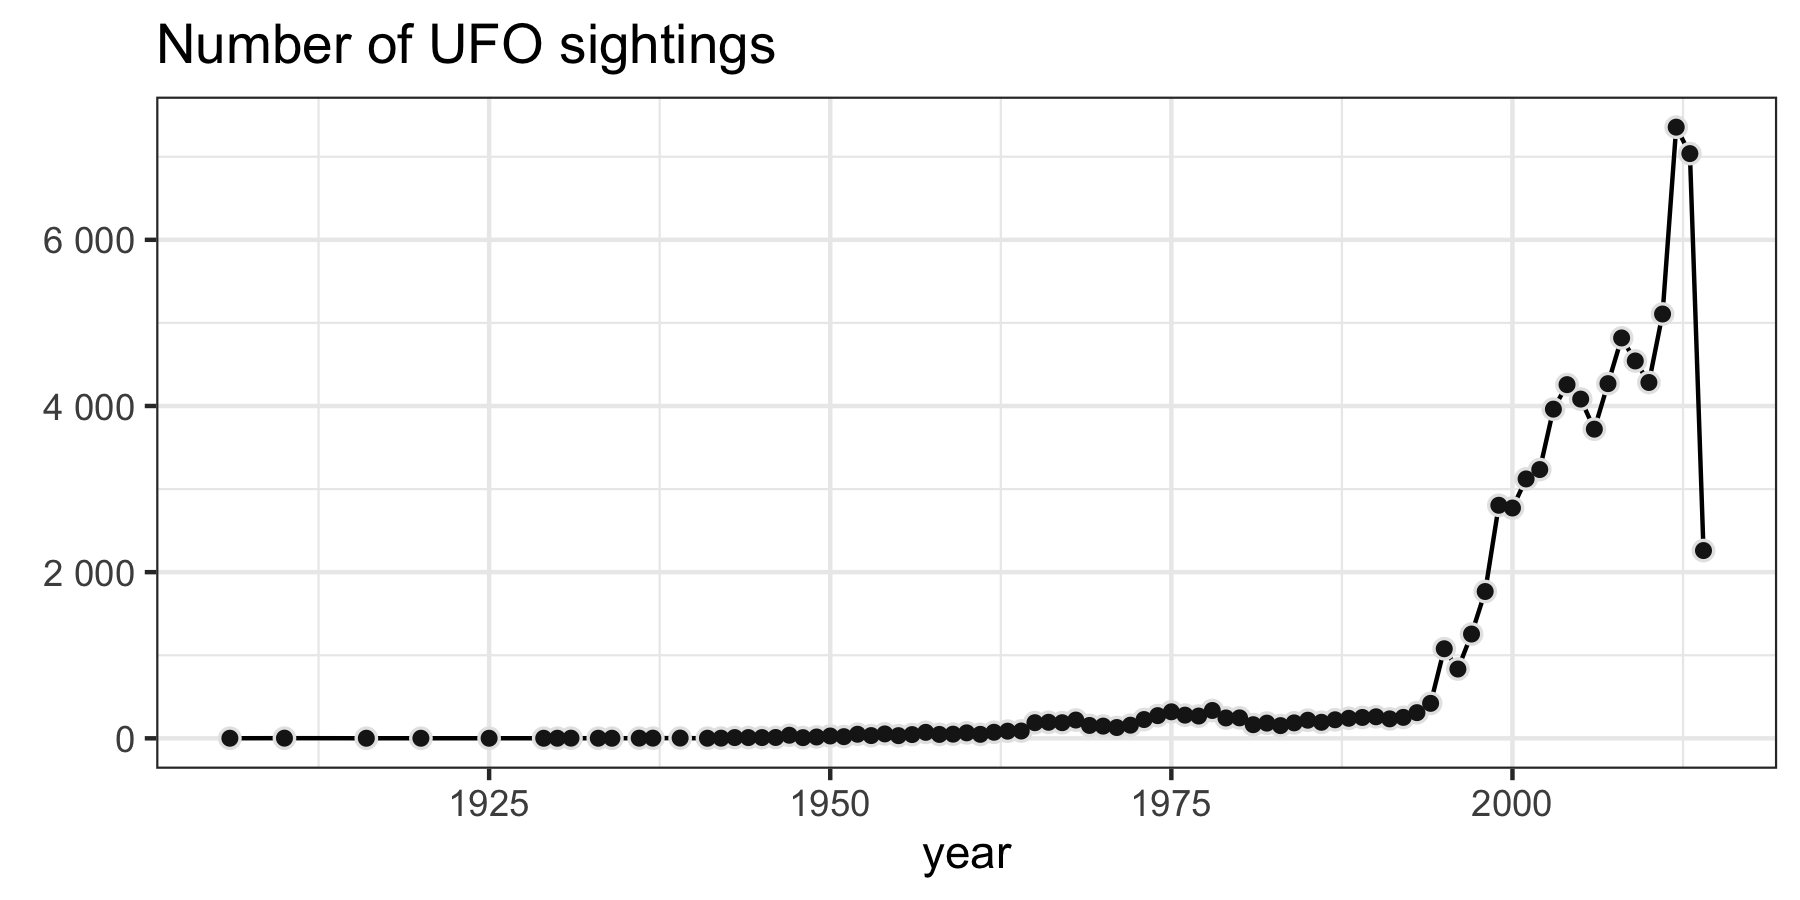

year  freq
0   2014  2260
1   2013  7038
2   2012  7356
3   2011  5107
4   2010  4283
5   2009  4542
6   2008  4819
7   2007  4269
8   2006  3721
9   2005  4083
10  2004  4257
11  2003  3962
12  2002  3235
13  2001  3122
14  2000  2772
15  1999  2805
16  1998  1767
17  1997  1255
18  1996   834
19  1995  1078
20  1994   421
21  1993   309
22  1992   252
23  1991   234
24  1990   259
25  1989   251
26  1988   241
27  1987   223
28  1986   193
29  1985   218

In [16]:
# number of sightings over time
ggshow("""
x$datetime <- as.POSIXct(x$datetime)
ggplot(x, aes(datetime)) + 
  geom_histogram(color="grey90") +
  ggtitle("Number of UFO sightings") +
  scale_y_continuous(labels=scales::number_format(1)) +
  ylab(element_blank()) +
  theme_bw() 
""", savesize=(6,3), dispwidth=700, x=x[["datetime"]])

tmp = x.datetime.dt.year.value_counts().sort_index(ascending=False)
tmp = pd.DataFrame(tmp).reset_index()
tmp.columns = ["year", "freq"]
ggshow("""
ggplot(x, aes(year, freq)) + 
  geom_line() +
  geom_point(size=2, color="grey90") +
  geom_point(size=1.25, color="grey10") +
  ggtitle("Number of UFO sightings") +
  scale_y_continuous(labels=scales::number_format(1)) +
  ylab(element_blank()) +
  theme_bw()
""", savesize=(6,3), dispwidth=700, x=tmp)

display(tmp.head(30))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


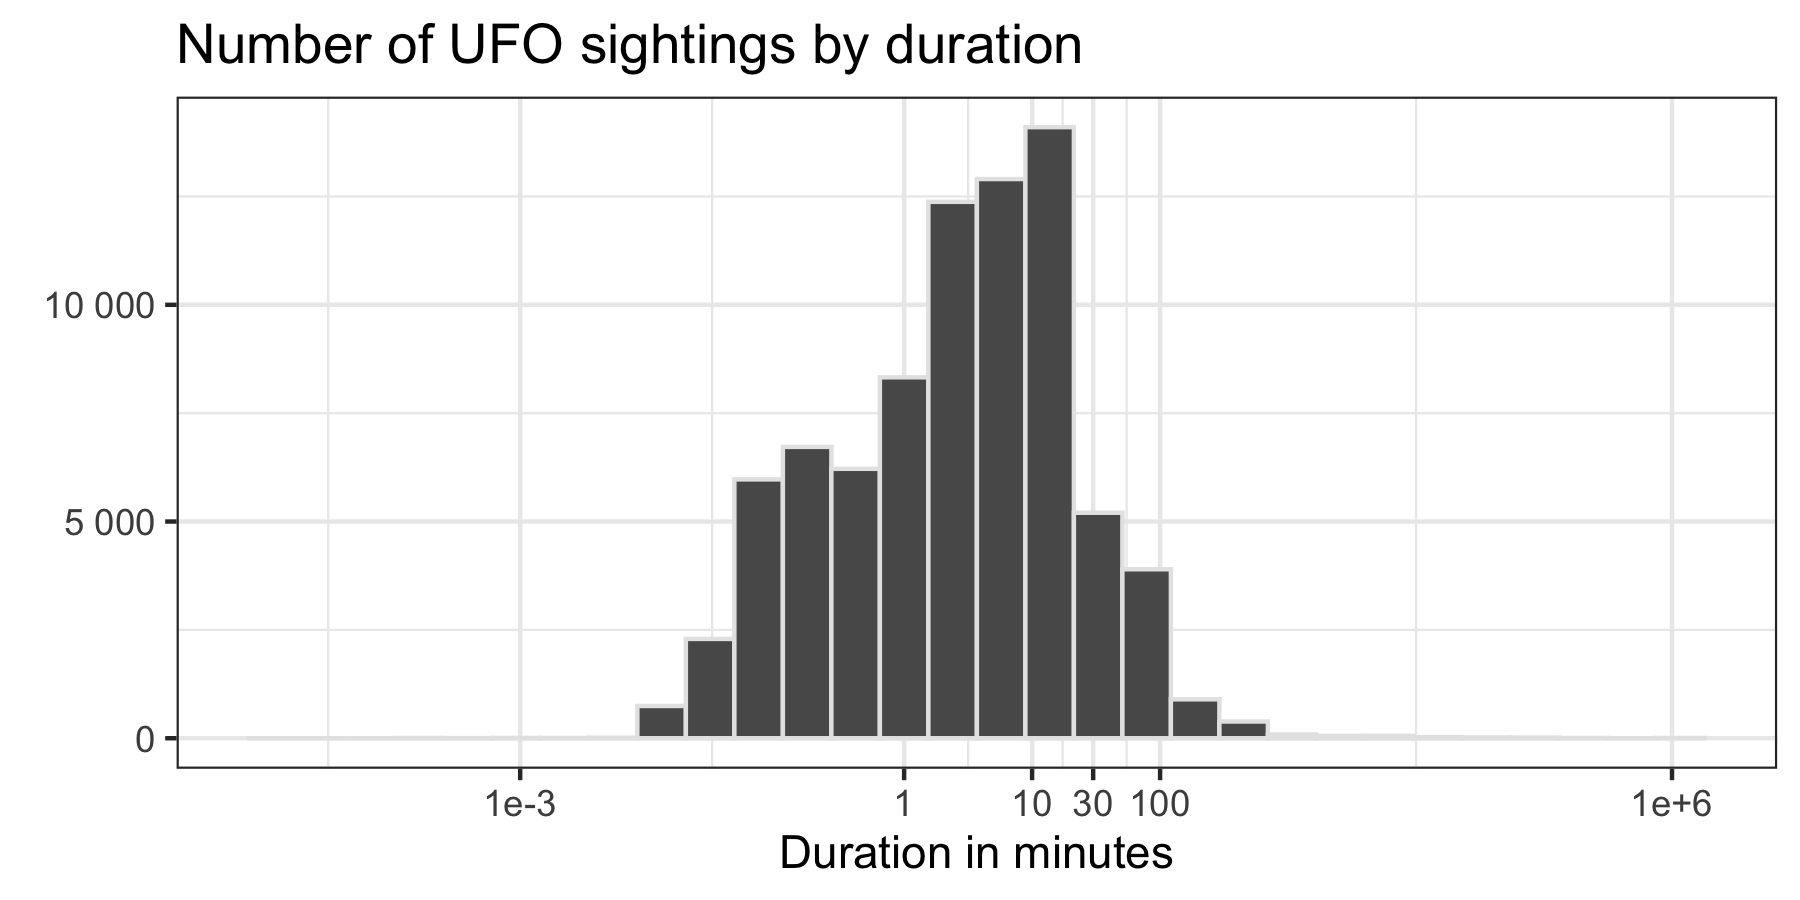

0.10     0.083333
0.15     0.166667
0.20     0.333333
0.25     0.500000
0.30     1.000000
0.35     1.000000
0.40     2.000000
0.45     2.000000
0.50     3.000000
0.55     4.000000
0.60     5.000000
0.65     5.000000
0.70    10.000000
0.75    10.000000
0.80    15.000000
0.85    20.000000
0.90    30.000000
0.95    60.000000
Name: duration_sec, dtype: float64

In [17]:
# duration distribution
ggshow("""
ggplot(x, aes(duration_sec/60)) + 
  geom_histogram(color="grey90") +
  ggtitle("Number of UFO sightings by duration") +
  #scale_x_continuous(breaks=[-3,0,3,6], labels=["1e-3", "1", "",]) +
  scale_x_log10(breaks=10^c(-3,0,1,log10(30),2,6), labels=c("1e-3", "1", "10", "30", "100", "1e+6")) +
  scale_y_continuous(labels=scales::number_format(1)) +
  xlab("Duration in minutes") +
  ylab(element_blank()) +
  theme_bw() 
""", savesize=(6,3), dispwidth=700, x=x.loc[~x.duration_sec.isna(), ["duration_sec"]])

(x.duration_sec / 60).quantile(q=np.arange(0.1,1,0.05))

light        16565
triangle      7865
circle        7608
fireball      6208
other         5649
unknown       5584
sphere        5387
disk          5213
oval          3733
formation     2457
cigar         2057
changing      1962
flash         1328
rectangle     1297
cylinder      1283
diamond       1178
chevron        952
egg            759
teardrop       750
cone           316
cross          233
delta            7
round            2
crescent         2
pyramid          1
flare            1
hexagon          1
dome             1
changed          1
Name: shape, dtype: int64

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


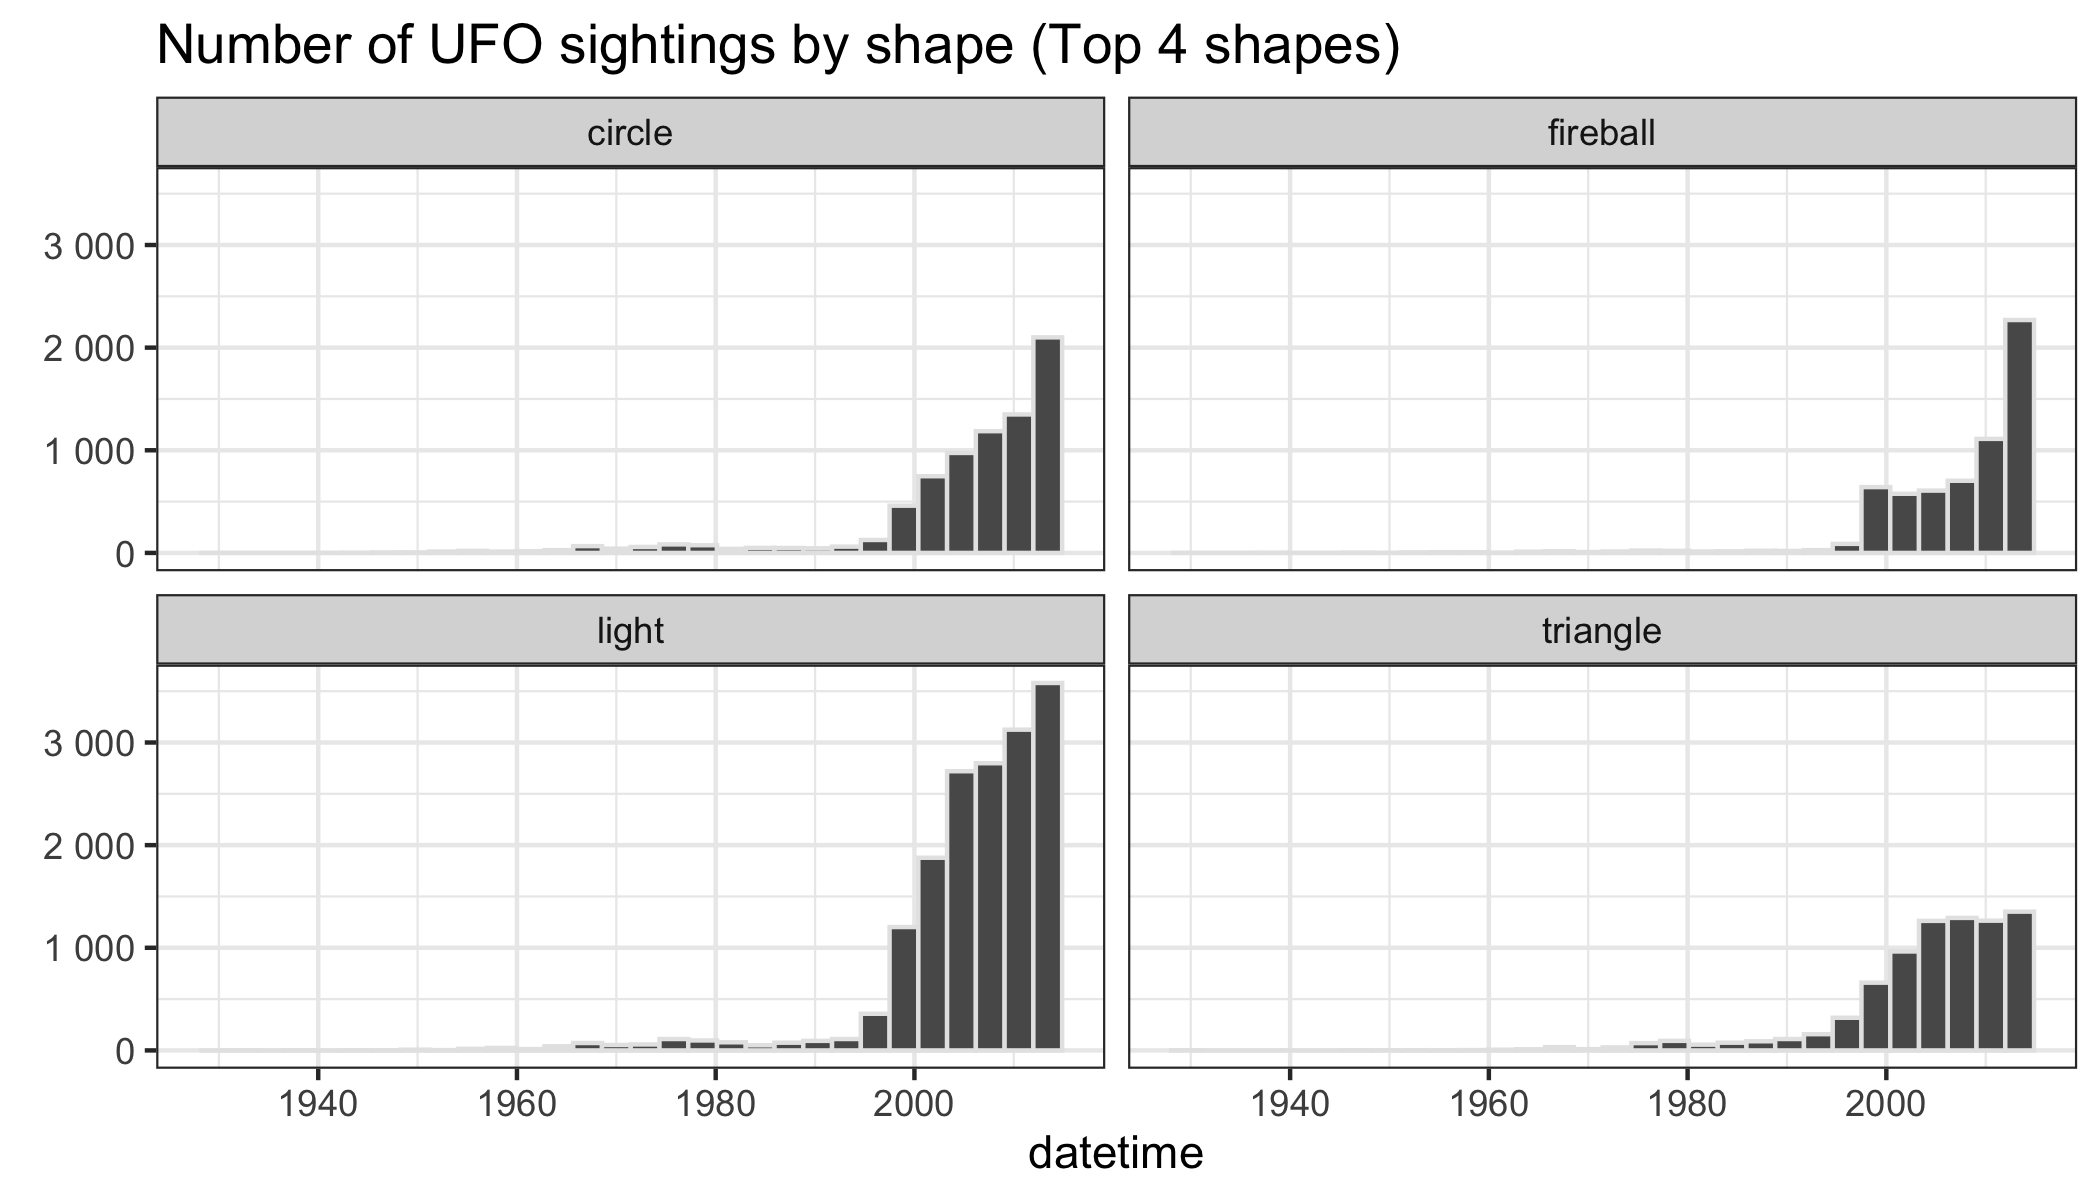

In [18]:
# shape distribution over time
tmp = x["shape"].value_counts()
display(tmp)

ggshow("""
x$datetime <- as.POSIXct(x$datetime)
ggplot(x, aes(datetime)) + 
  facet_wrap(vars(shape)) +
  geom_histogram(color="grey90", size=0.5) +
  ggtitle("Number of UFO sightings by shape (Top 4 shapes)") +
  scale_y_continuous(labels=scales::number_format(1)) +
  ylab(element_blank()) +
  theme_bw() 
""", savesize=(7,4), dispwidth=800, x=x.loc[x["shape"].isin(tmp.index[0:4]), ["datetime", "shape"]])
None

Zoom level 1 is chosen


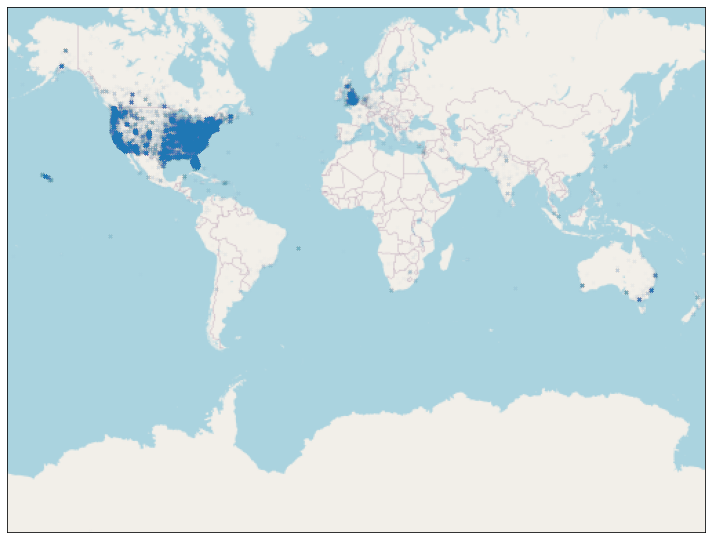

In [19]:
bounds = x.longitude.min(), x.latitude.min(), x.longitude.max(), x.latitude.max()
fig, ax = plt.subplots(figsize=(12.5, 10))
draw_map(bounds, ax=ax, extent_crs="webmap")
ax.tick_params(axis="both", which="both", bottom=False, left=False, labelleft=False, labelbottom=False)

ax.scatter(x.longitude_proj, x.latitude_proj, s=10, alpha=0.01, marker="x")
None

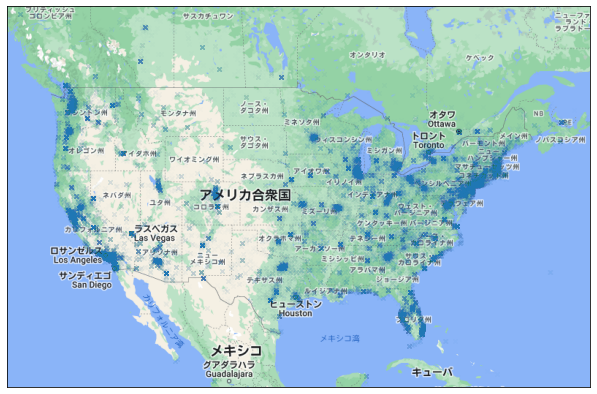

In [20]:
bounds = -130, 20, -60, 55
fig, ax = plt.subplots(figsize=(13, 7))
draw_map(bounds, ax=ax, extent_crs="webmap", z=4, tile="google")
ax.tick_params(axis="both", which="both", bottom=False, left=False, labelleft=False, labelbottom=False)

flg = (x.longitude >= bounds[0]) & (x.longitude <= bounds[2]) & (x.latitude >= bounds[1]) & (x.latitude <= bounds[3])
ax.scatter(x.longitude_proj[flg], x.latitude_proj[flg], s=20, alpha=0.01, marker="x")
None

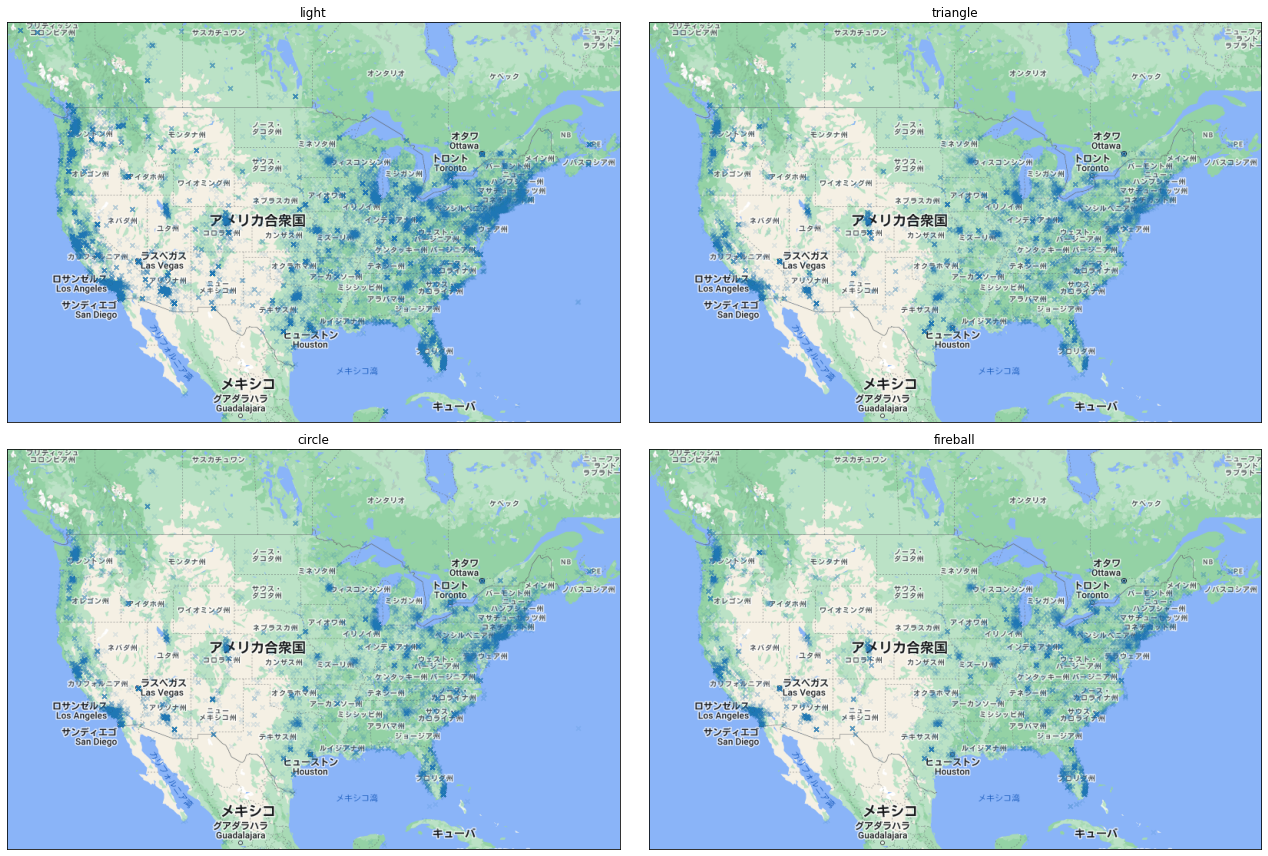

In [21]:
# by shape
bounds = -130, 20, -60, 55
tmp = x["shape"].value_counts()
shapes = tmp.sort_values(ascending=False).index[0:4]

fig, ax = plt.subplots(2, 2, figsize=(18, 12))
for i, s in enumerate(shapes):
  r, c = int(i/2), i%2
  a = ax[r][c]
  a.set_title(s)
  draw_map(bounds, ax=a, extent_crs="webmap", z=4, tile="google")
  a.tick_params(axis="both", which="both", bottom=False, left=False, labelleft=False, labelbottom=False)
  flg = (x.longitude >= bounds[0]) & (x.longitude <= bounds[2]) & (x.latitude >= bounds[1]) & (x.latitude <= bounds[3]) & (x["shape"] == s)
  a.scatter(x.longitude_proj[flg], x.latitude_proj[flg], s=20, alpha=0.1, marker="x")
fig.tight_layout()
None

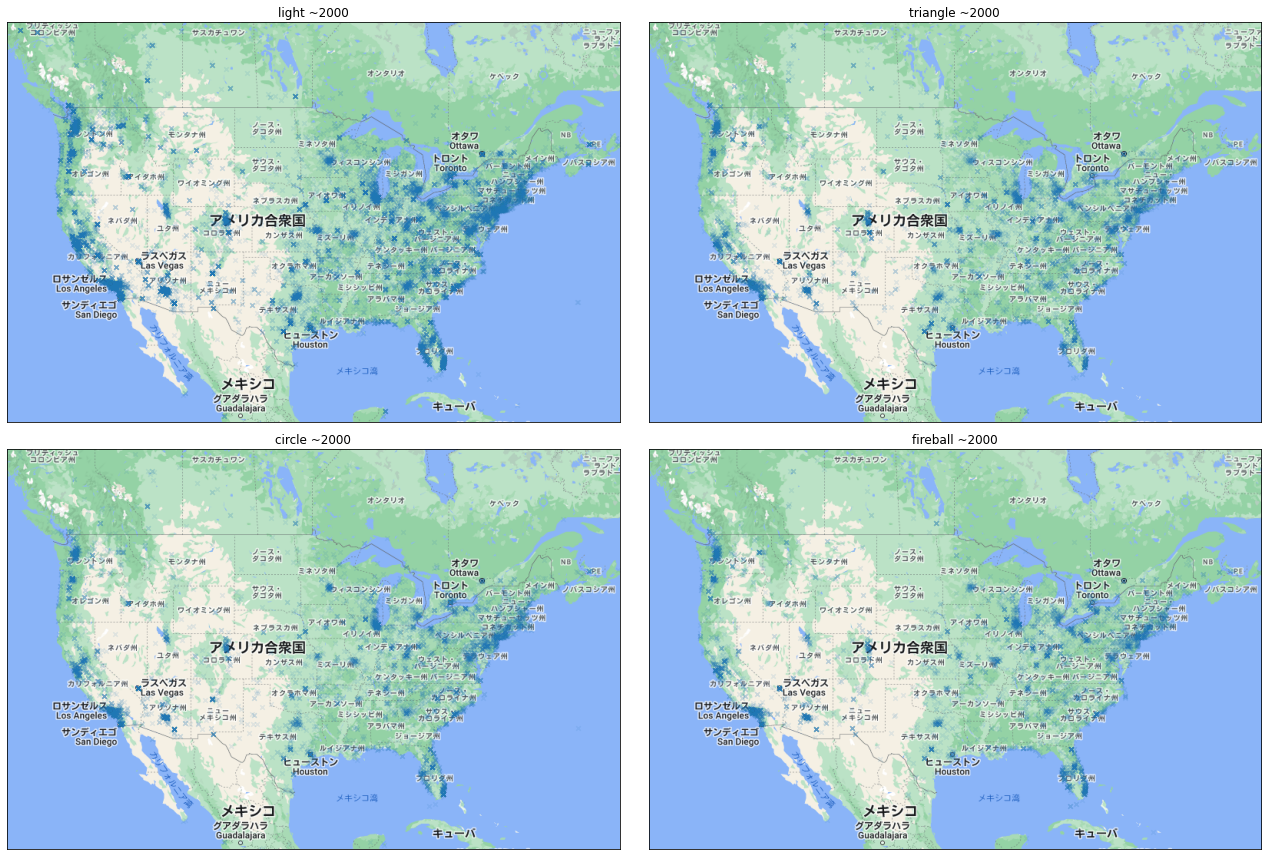

In [22]:
# by shape, since 2000 years
bounds = -130, 20, -60, 55
tmp = x["shape"].value_counts()
shapes = tmp.sort_values(ascending=False).index[0:4]

fig, ax = plt.subplots(2, 2, figsize=(18, 12))
for i, s in enumerate(shapes):
  r, c = int(i/2), i%2
  a = ax[r][c]
  a.set_title("{} ~2000".format(s))
  draw_map(bounds, ax=a, extent_crs="webmap", z=4, tile="google")
  a.tick_params(axis="both", which="both", bottom=False, left=False, labelleft=False, labelbottom=False)
  flg = (x.longitude >= bounds[0]) & (x.longitude <= bounds[2]) & (x.latitude >= bounds[1]) & (x.latitude <= bounds[3]) & (x["shape"] == s) & (x.datetime.dt.year >= 2000)
  a.scatter(x.longitude_proj[flg], x.latitude_proj[flg], s=20, alpha=0.1, marker="x")
fig.tight_layout()
None

`geom_smooth()` using formula 'y ~ x'


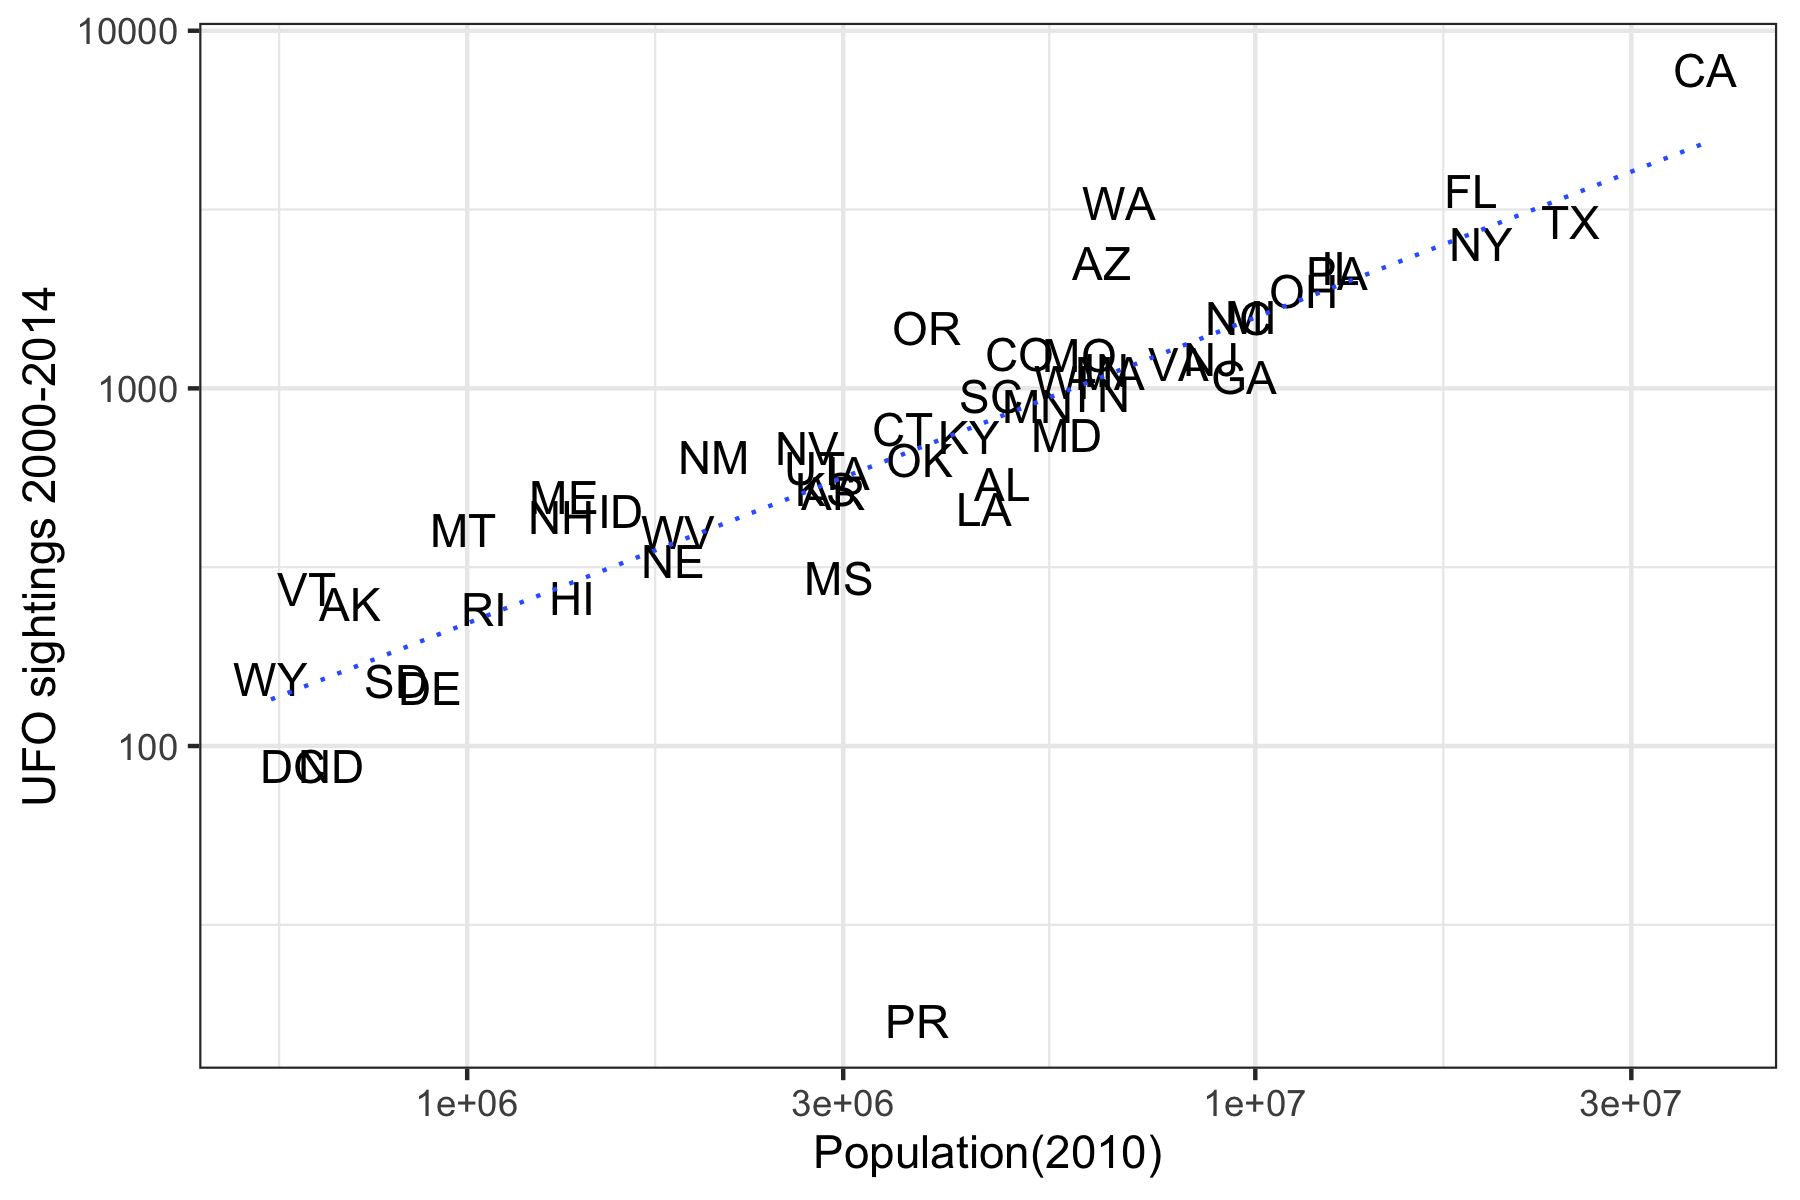

`geom_smooth()` using formula 'y ~ x'


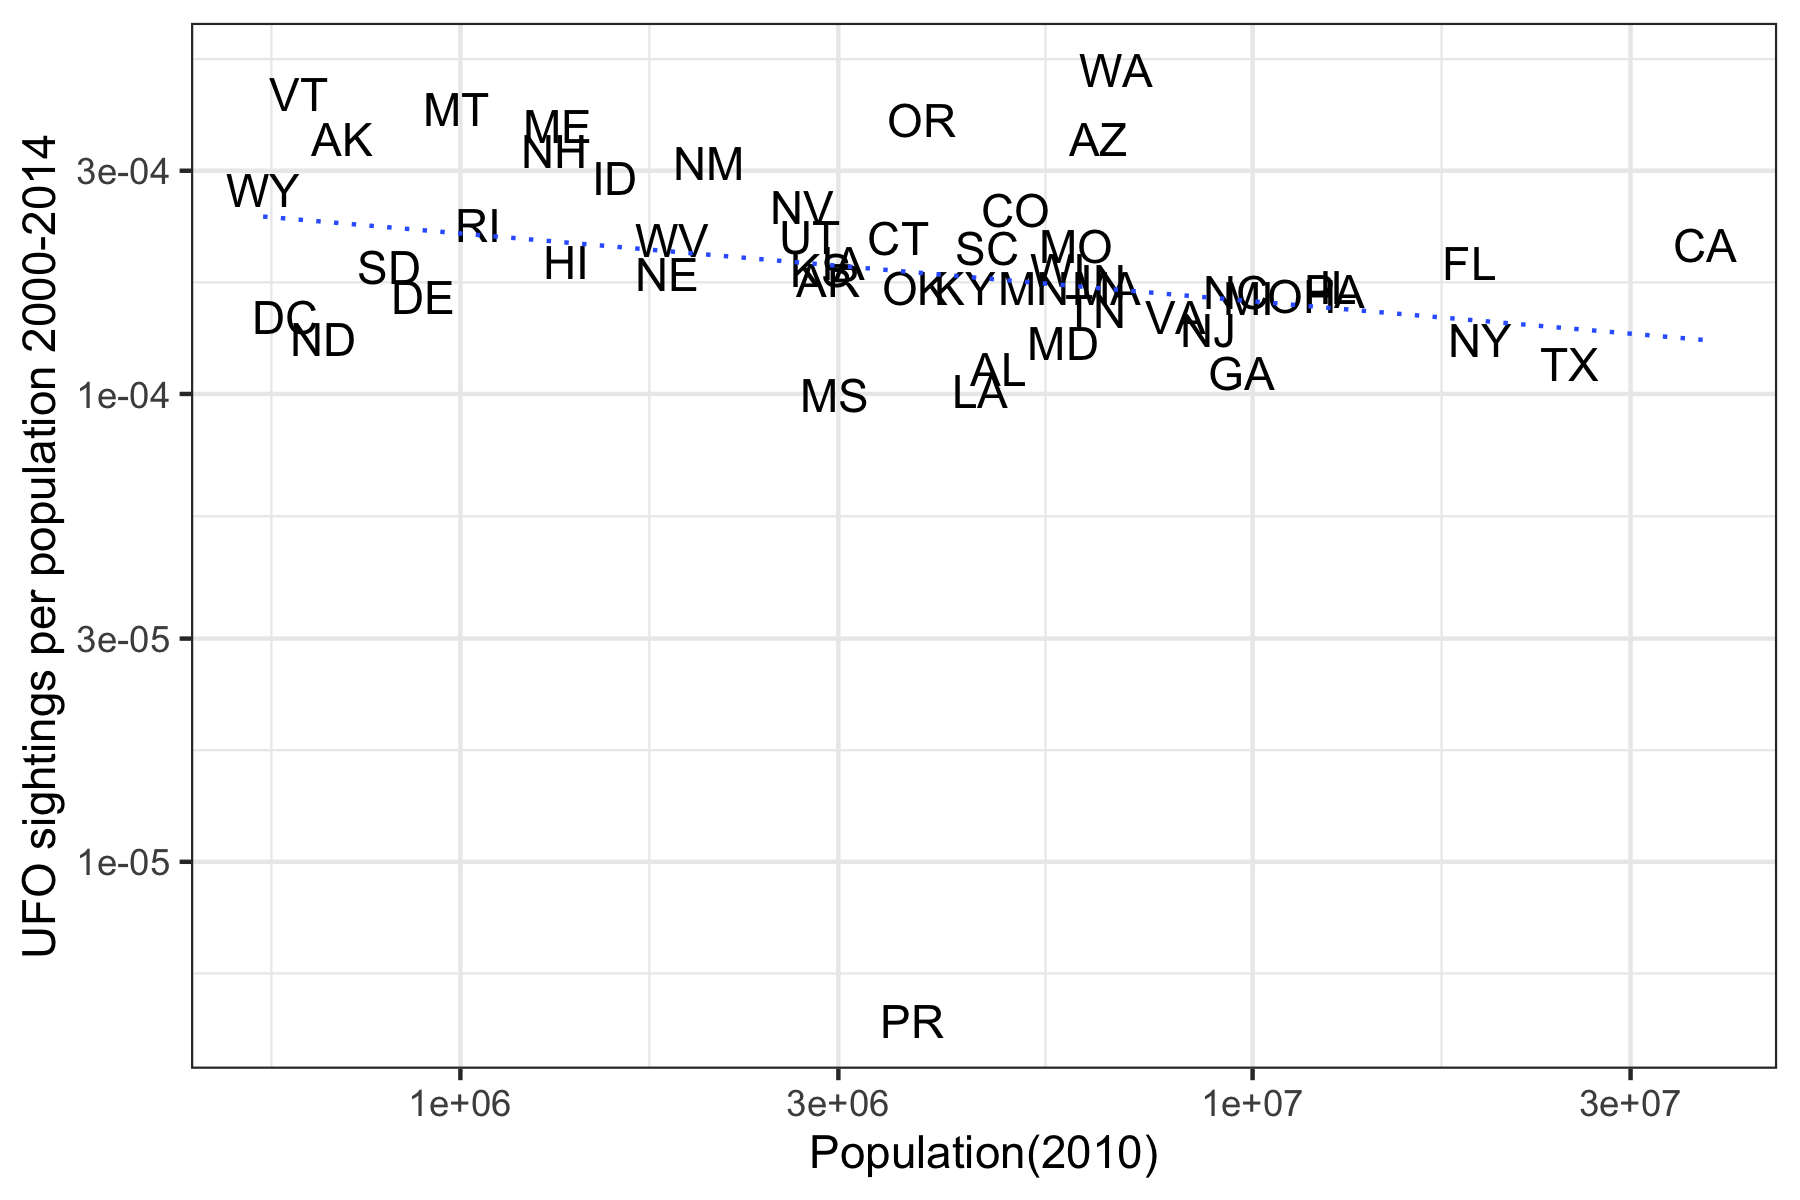

`geom_smooth()` using formula 'y ~ x'


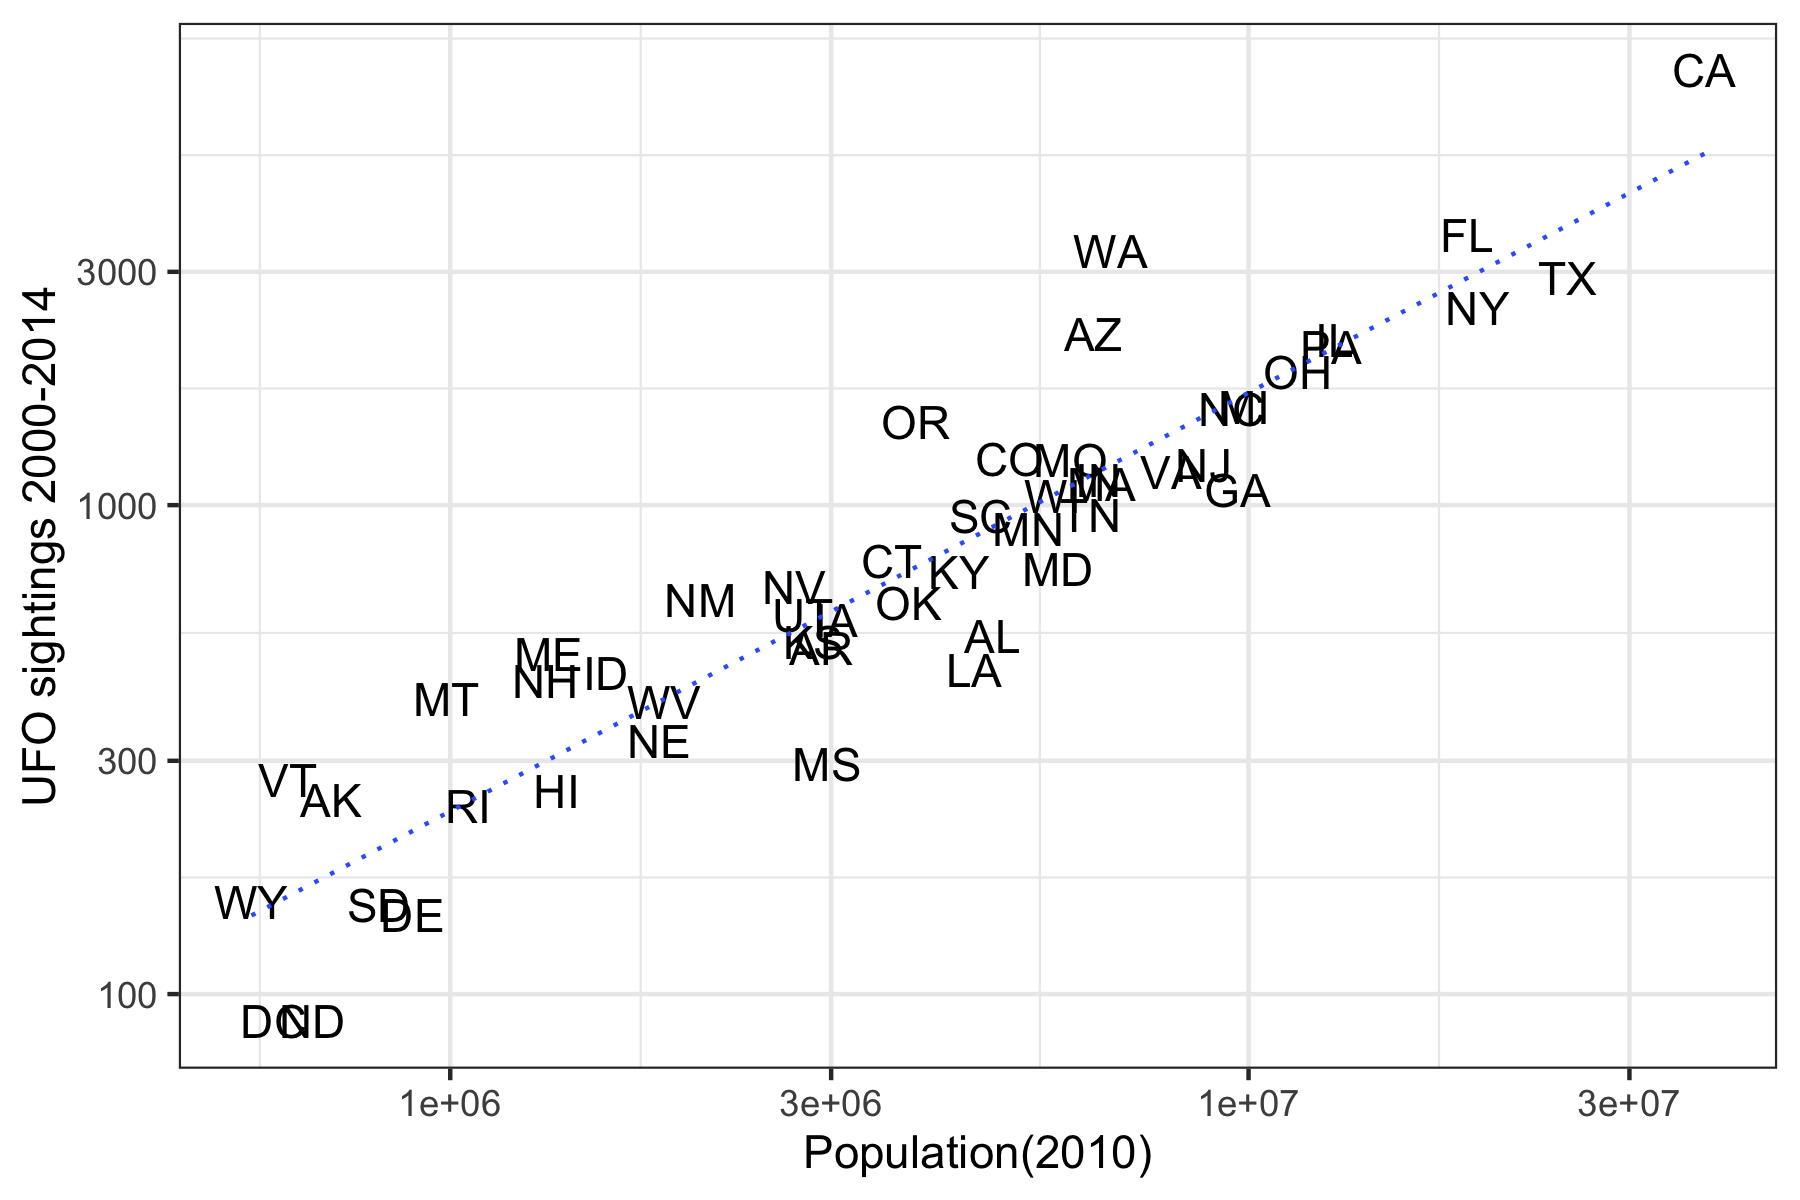

`geom_smooth()` using formula 'y ~ x'


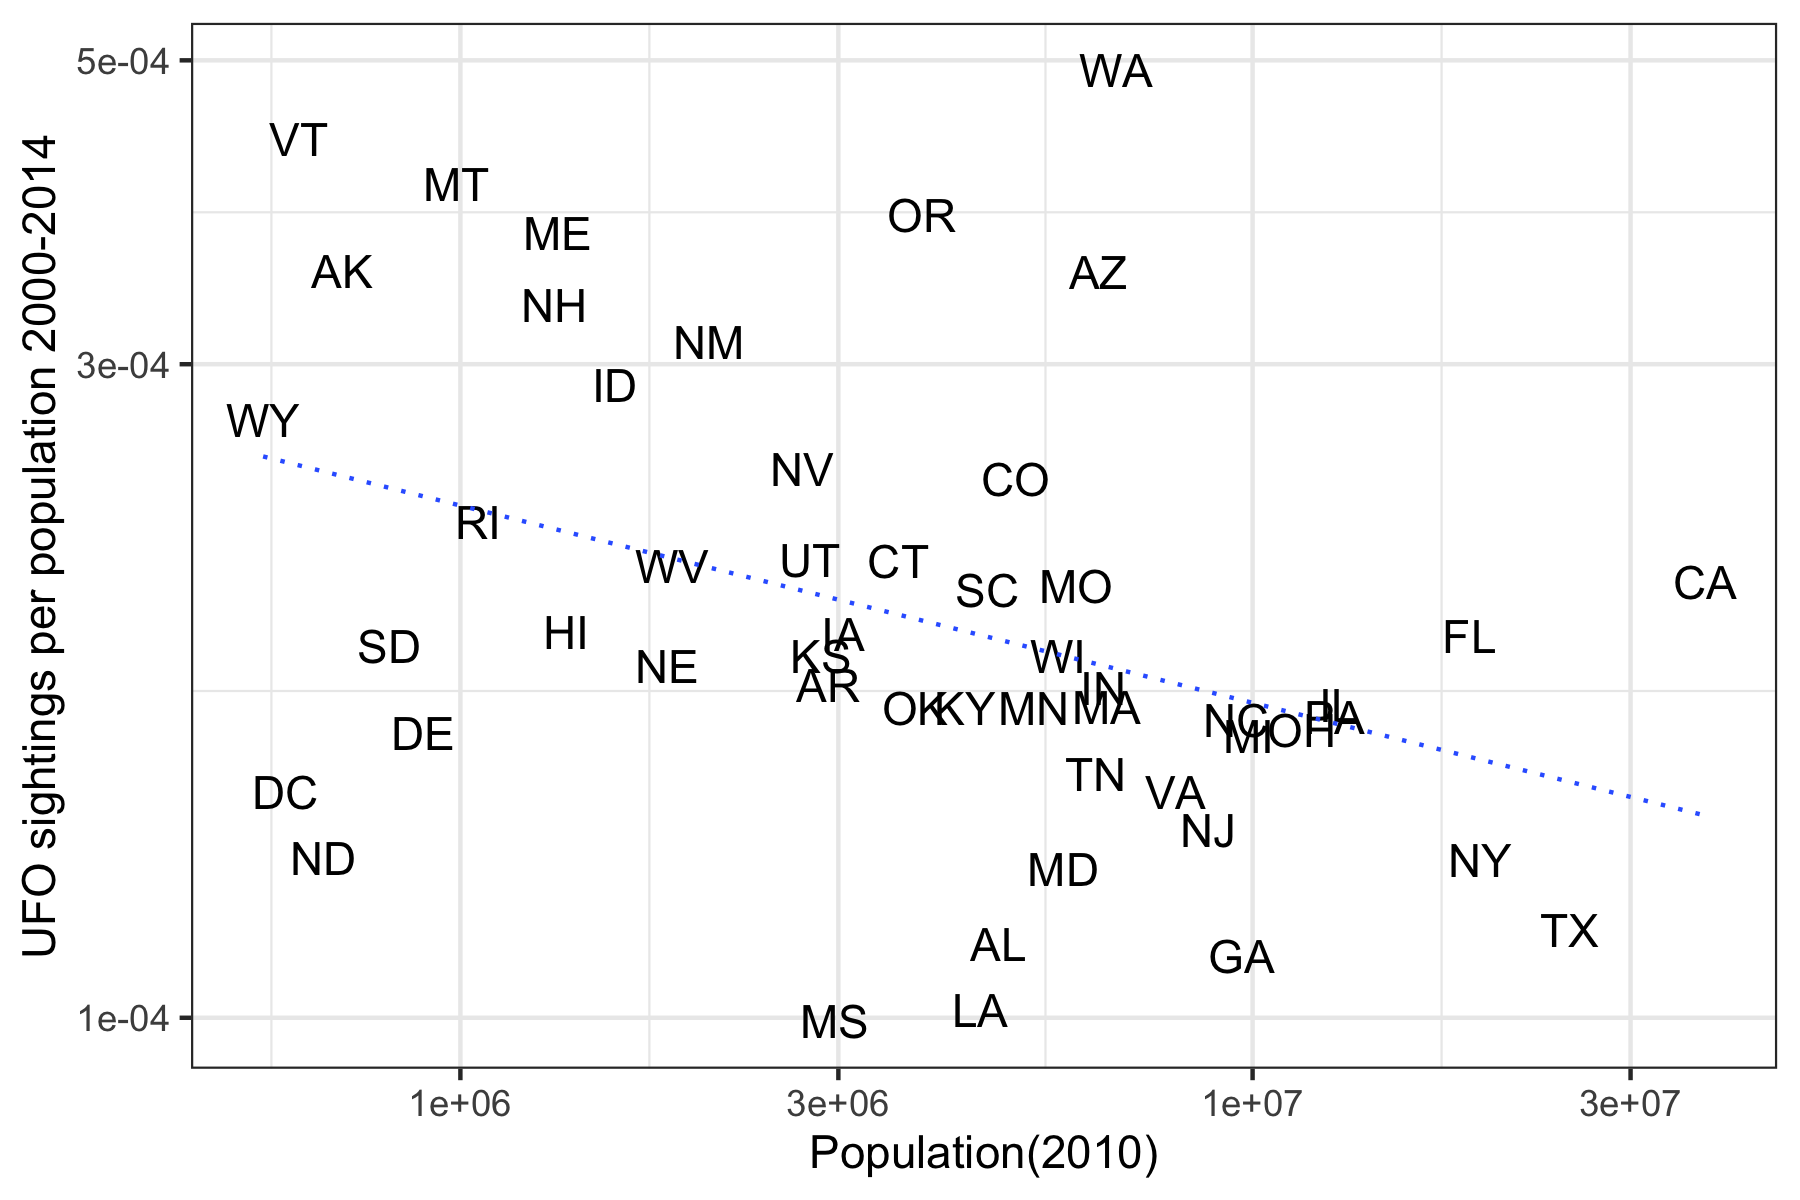

In [23]:
# population and ufo sighting by state, year 2000+
tmp = x[x.year2000p].groupby(["state_code", "state_name"], as_index=False).agg(
  ufo_sighting=("shape", "size"), population=("statepop2010", "mean"))

ggshow("""
ggplot(x, aes(population, ufo_sighting)) +
  geom_text(aes(label=state_code)) +
  geom_smooth(method="lm", linetype="dotted", size=0.5, se=FALSE) +
  scale_x_log10() +
  scale_y_log10() +
  xlab("Population(2010)") +
  ylab("UFO sightings 2000-2014") +
  theme_bw()
""", savesize=(6,4), dispwidth=700, x=tmp)

ggshow("""
ggplot(x, aes(population, ufo_sighting/population)) +
  geom_text(aes(label=state_code)) +
  geom_smooth(method="lm", linetype="dotted", size=0.5, se=FALSE) +
  scale_x_log10() +
  scale_y_log10() +
  xlab("Population(2010)") +
  ylab("UFO sightings per population 2000-2014") +
  theme_bw()
""", savesize=(6,4), dispwidth=700, x=tmp)

# except for PR
ggshow("""
ggplot(x, aes(population, ufo_sighting)) +
  geom_text(aes(label=state_code)) +
  geom_smooth(method="lm", linetype="dotted", size=0.5, se=FALSE) +
  scale_x_log10() +
  scale_y_log10() +
  xlab("Population(2010)") +
  ylab("UFO sightings 2000-2014") +
  theme_bw()
""", savesize=(6,4), dispwidth=700, x=tmp[tmp.state_code != "PR"])

ggshow("""
ggplot(x, aes(population, ufo_sighting/population)) +
  geom_text(aes(label=state_code)) +
  geom_smooth(method="lm", linetype="dotted", size=0.5, se=FALSE) +
  scale_x_log10() +
  scale_y_log10() +
  xlab("Population(2010)") +
  ylab("UFO sightings per population 2000-2014") +
  theme_bw()
""", savesize=(6,4), dispwidth=700, x=tmp[tmp.state_code != "PR"])
None

In [24]:
display(tmp.corr())
display(tmp[tmp.state_code != "PR"].corr())

tmp["ufo_sighting_per_pop"] = tmp.ufo_sighting / tmp.population

ufo_sighting  population
ufo_sighting      1.000000    0.916897
population        0.916897    1.000000

ufo_sighting  population
ufo_sighting      1.000000    0.918944
population        0.918944    1.000000

In [25]:
tmp["one"] = 1
model = sm.OLS(np.log(tmp.ufo_sighting), pd.concat([tmp.one, np.log(tmp.population)], axis=1)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           ufo_sighting   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                     98.06
Date:                Sat, 14 May 2022   Prob (F-statistic):           2.23e-13
Time:                        21:40:46   Log-Likelihood:                -49.254
No. Observations:                  52   AIC:                             102.5
Df Residuals:                      50   BIC:                             106.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
one           -6.4166      1.308     -4.905      0.000      -9.044      -3.789
population     0.8550      0.086      9.902      0.000       0.682       1.028
==============================================================================
Omnibus:                       75.703   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1064.373
Skew:                          -3.787   Prob(JB):                    7.49e-232
Kurtosis:                      23.830   Cond. No.                         226.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
# Make daily count data by US state
tmp = x[x.year2000p & x.usa].copy()
tmp["day"] = tmp.datetime.dt.strftime("%Y-%m-%d")
d1 = tmp.groupby(["state_code", "day"], as_index=False).agg(freq=("shape", "size"))
d2 = tmp[tmp.duration_sec >= 60*30].groupby(["state_code", "day"], as_index=False).agg(freq_30min=("shape", "size"))
d3 = tmp[tmp["shape"]=="circle"].groupby(["state_code", "day"], as_index=False).agg(freq_circle=("shape", "size"))
d = pd.merge(d1, d2, on=["day", "state_code"], how="outer")
d = pd.merge(d, d3, on=["day", "state_code"], how="outer")

# fill missing days by zeros
start, end = datetime.strptime(tmp.day.min(), '%Y-%m-%d'), datetime.strptime(tmp.day.max(), '%Y-%m-%d')
days = pd.date_range(start, end, freq="1D").astype(str)
states = tmp.state_code.unique()
tmp2 = pd.DataFrame(itertools.product(days, states), columns=["day", "state_code"])
d = pd.merge(tmp2, d, on=["day", "state_code"], how="left")
d.freq.fillna(0, inplace=True)
d.freq_30min.fillna(0, inplace=True)
d.freq_circle.fillna(0, inplace=True)

# merge pop
tmp = x.groupby("state_code", as_index=False).agg(pop=("statepop2010", "mean"))
d = pd.merge(d, tmp, on="state_code")
d

day state_code  freq  freq_30min  freq_circle        pop
0       2000-01-01         MO   0.0         0.0          0.0  5988927.0
1       2000-01-02         MO   0.0         0.0          0.0  5988927.0
2       2000-01-03         MO   0.0         0.0          0.0  5988927.0
3       2000-01-04         MO   1.0         1.0          0.0  5988927.0
4       2000-01-05         MO   3.0         0.0          0.0  5988927.0
...            ...        ...   ...         ...          ...        ...
272579  2014-05-04         PR   0.0         0.0          0.0  3725789.0
272580  2014-05-05         PR   0.0         0.0          0.0  3725789.0
272581  2014-05-06         PR   0.0         0.0          0.0  3725789.0
272582  2014-05-07         PR   0.0         0.0          0.0  3725789.0
272583  2014-05-08         PR   0.0         0.0          0.0  3725789.0

[272584 rows x 6 columns]

In [27]:
(d.freq > 0).mean(), (d.freq_30min > 0).mean(), (d.freq_circle > 0).mean()

(0.1501482111936137, 0.023299239867343644, 0.018995979221084144)

In [155]:
for s in d.state_code.unique():
  d[s] = (d.state_code==s).astype(float)
d

day state_code  freq  freq_30min  freq_circle        pop   MO  \
0       2000-01-01         MO   0.0         0.0          0.0  5988927.0  1.0   
1       2000-01-02         MO   0.0         0.0          0.0  5988927.0  1.0   
2       2000-01-03         MO   0.0         0.0          0.0  5988927.0  1.0   
3       2000-01-04         MO   1.0         1.0          0.0  5988927.0  1.0   
4       2000-01-05         MO   3.0         0.0          0.0  5988927.0  1.0   
...            ...        ...   ...         ...          ...        ...  ...   
272579  2014-05-04         PR   0.0         0.0          0.0  3725789.0  0.0   
272580  2014-05-05         PR   0.0         0.0          0.0  3725789.0  0.0   
272581  2014-05-06         PR   0.0         0.0          0.0  3725789.0  0.0   
272582  2014-05-07         PR   0.0         0.0          0.0  3725789.0  0.0   
272583  2014-05-08         PR   0.0         0.0          0.0  3725789.0  0.0   

         FL   WI   KY  ...   ME   MD   KS   WY   SD   MT   DC   ND   DE   PR  
0       0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1       0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2       0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3       0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4       0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
272579  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
272580  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
272581  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
272582  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
272583  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  

[272584 rows x 58 columns]

In [30]:
# poisson regression is easier with R
# so we pass the data via the disk
d.to_csv("regdata.csv", index=False)

In [31]:
# poisson regression result from R
o = pd.read_csv("poisson-res.csv")
o

state      coef        se   model
0      AK -7.174697  0.063372     all
1      AL -7.665704  0.042993     all
2      AR -7.476702  0.044281     all
3      AZ -7.175275  0.021138     all
4      CA -7.401536  0.011361     all
..    ...       ...       ...     ...
151    VT -8.100918  0.196116  circle
152    WA -8.083267  0.058621  circle
153    WI -8.429056  0.094916  circle
154    WV -8.353903  0.152499  circle
155    WY -8.356545  0.277350  circle

[156 rows x 4 columns]

In [49]:
geo_state

STATEFP                                           geometry  \
0       01  POLYGON ((-87.59206 30.95146, -87.63494 30.865...   
1       02  MULTIPOLYGON (((-179.17426 51.27906, -178.9955...   
2       04  POLYGON ((-112.36504 31.74113, -113.33377 32.0...   
3       05  POLYGON ((-93.23861 33.01802, -93.37713 33.018...   
4       06  MULTIPOLYGON (((-121.90647 36.96895, -121.9516...   
5       08  POLYGON ((-106.87729 37.00014, -107.42091 37.0...   
6       09  POLYGON ((-73.54415 41.36632, -73.54331 41.375...   
7       10  POLYGON ((-75.30255 38.93900, -75.30408 38.913...   
8       11  POLYGON ((-77.11976 38.93434, -77.04102 38.995...   
9       12  MULTIPOLYGON (((-82.75938 29.00662, -82.75970 ...   
10      13  POLYGON ((-84.86346 30.71150, -84.86469 30.711...   
11      15  MULTIPOLYGON (((-155.94926 19.85703, -155.9156...   
12      16  POLYGON ((-113.00082 41.99822, -113.24916 41.9...   
13      17  POLYGON ((-90.26110 38.51826, -90.25529 38.530...   
14      18  POLYGON ((-86.92775 37.93496, -86.97774 37.925...   
15      19  POLYGON ((-94.91490 40.57492, -95.06892 40.576...   
16      20  POLYGON ((-102.04197 37.73854, -102.04425 38.1...   
17      21  POLYGON ((-89.27893 36.57770, -89.22732 36.569...   
18      22  POLYGON ((-93.70634 30.05218, -93.70394 30.054...   
19      23  MULTIPOLYGON (((-69.39329 43.95642, -69.42205 ...   
20      24  MULTIPOLYGON (((-76.40289 38.31140, -76.37448 ...   
21      25  MULTIPOLYGON (((-71.49822 42.01587, -71.55944 ...   
22      26  MULTIPOLYGON (((-86.22607 41.76002, -86.22609 ...   
23      27  POLYGON ((-95.86095 43.49999, -96.05316 43.500...   
24      28  POLYGON ((-90.25955 31.00066, -90.34601 31.000...   
25      29  POLYGON ((-94.61796 36.99891, -94.61810 37.056...   
26      30  POLYGON ((-111.43879 44.72055, -111.45695 44.6...   
27      31  POLYGON ((-101.32551 40.00257, -101.41103 40.0...   
28      32  POLYGON ((-118.50096 37.94902, -118.94967 38.2...   
29      33  POLYGON ((-72.49260 42.96765, -72.44498 43.004...   
30      34  POLYGON ((-74.91516 39.17670, -74.99800 39.191...   
31      35  POLYGON ((-109.04724 33.20890, -109.04724 33.2...   
32      36  MULTIPOLYGON (((-76.46215 41.99893, -76.47303 ...   
33      37  POLYGON ((-84.12945 34.98795, -84.32187 34.988...   
34      38  POLYGON ((-102.08755 45.94460, -102.32823 45.9...   
35      39  MULTIPOLYGON (((-83.85209 38.75143, -83.90438 ...   
36      40  POLYGON ((-98.22528 34.12724, -98.31875 34.146...   
37      41  POLYGON ((-122.50114 42.00846, -122.80008 42.0...   
38      42  POLYGON ((-78.80830 39.72307, -78.92842 39.723...   
39      44  MULTIPOLYGON (((-71.54541 41.24273, -71.53408 ...   
40      45  POLYGON ((-81.75513 33.15155, -81.76251 33.197...   
41      46  POLYGON ((-101.00043 42.99753, -101.22801 42.9...   
42      47  POLYGON ((-87.85189 35.00566, -87.98492 35.005...   
43      48  POLYGON ((-102.07365 29.78693, -102.11568 29.7...   
44      49  POLYGON ((-112.35769 37.00102, -112.53857 37.0...   
45      50  POLYGON ((-72.44056 43.21525, -72.45040 43.161...   
46      51  MULTIPOLYGON (((-82.48724 36.59582, -82.60918 ...   
47      53  MULTIPOLYGON (((-122.43867 45.56358, -122.4922...   
48      54  POLYGON ((-80.88325 37.38393, -80.83548 37.334...   
49      55  MULTIPOLYGON (((-90.64284 42.50848, -90.67273 ...   
50      56  POLYGON ((-111.04669 42.00157, -111.04708 42.3...   
51      72  MULTIPOLYGON (((-66.97870 17.95729, -66.98221 ...   

              state_name state_code state_fips  statepop2021  statepop2010  
0                Alabama         AL         01       5039877       4779736  
1                 Alaska         AK         02        733391        710231  
2                Arizona         AZ         04       7276316       6392017  
3               Arkansas         AR         05       3011524       2915918  
4             California         CA         06      39237836      37253956  
5               Colorado         CO         08       5812069       5029196  
6            Conne

In [51]:
%time geo_state = cb.dissolve(by="STATEFP").reset_index()[["STATEFP", "geometry"]]
geo_state = pd.merge(geo_state, stateinfo, left_on="STATEFP", right_on="state_fips")
geo_state = pd.merge(geo_state, o, left_on="state_code", right_on="state")
geo_state

CPU times: user 355 ms, sys: 2.83 ms, total: 358 ms
Wall time: 356 ms


STATEFP                                           geometry   state_name  \
0        01  POLYGON ((-87.59206 30.95146, -87.63494 30.865...      Alabama   
1        01  POLYGON ((-87.59206 30.95146, -87.63494 30.865...      Alabama   
2        01  POLYGON ((-87.59206 30.95146, -87.63494 30.865...      Alabama   
3        02  MULTIPOLYGON (((-179.17426 51.27906, -178.9955...       Alaska   
4        02  MULTIPOLYGON (((-179.17426 51.27906, -178.9955...       Alaska   
..      ...                                                ...          ...   
151      56  POLYGON ((-111.04669 42.00157, -111.04708 42.3...      Wyoming   
152      56  POLYGON ((-111.04669 42.00157, -111.04708 42.3...      Wyoming   
153      72  MULTIPOLYGON (((-66.97870 17.95729, -66.98221 ...  Puerto Rico   
154      72  MULTIPOLYGON (((-66.97870 17.95729, -66.98221 ...  Puerto Rico   
155      72  MULTIPOLYGON (((-66.97870 17.95729, -66.98221 ...  Puerto Rico   

    state_code state_fips  statepop2021  statepop2010 state      coef  \
0           AL         01       5039877       4779736    AL -7.665704   
1           AL         01       5039877       4779736    AL -8.501274   
2           AL         01       5039877       4779736    AL -8.691331   
3           AK         02        733391        710231    AK -7.174697   
4           AK         02        733391        710231    AK -8.002695   
..         ...        ...           ...           ...   ...       ...   
151         WY         56        576851        563626    WY -8.108760   
152         WY         56        576851        563626    WY -8.356545   
153         PR         72       3285874       3725789    PR -9.060266   
154         PR         72       3285874       3725789    PR -9.989685   
155         PR         72       3285874       3725789    PR -9.989685   

           se   model  
0    0.042993     all  
1    0.112509   30min  
2    0.140028  circle  
3    0.063372     all  
4    0.164399   30min  
..        ...     ...  
151  0.208514   30min  
152  0.277350  circle  
153  0.242478     all  
154  0.706841   30min  
155  0.706841  circle  

[156 rows x 11 columns]

In [63]:
geo_state.bounds

minx       miny        maxx       maxy
0    -88.468669  30.228314  -84.891841  35.008028
1    -88.468669  30.228314  -84.891841  35.008028
2    -88.468669  30.228314  -84.891841  35.008028
3   -179.174265  51.219862  179.773922  71.352561
4   -179.174265  51.219862  179.773922  71.352561
..          ...        ...         ...        ...
151 -111.056888  40.996346 -104.052287  45.005904
152 -111.056888  40.996346 -104.052287  45.005904
153  -67.955811  17.913769  -65.221568  18.511706
154  -67.955811  17.913769  -65.221568  18.511706
155  -67.955811  17.913769  -65.221568  18.511706

[156 rows x 4 columns]

In [72]:
geo_state.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [73]:
geo_state.centroid.x

/var/folders/ss/x2d7lbyd3t95y5lff7pvv4y80000gn/T/ipykernel_30326/594402438.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geo_state.centroid.x


0      -86.828385
1      -86.828385
2      -86.828385
3     -152.076694
4     -152.076694
          ...    
151   -107.551242
152   -107.551242
153    -66.456778
154    -66.456778
155    -66.456778
Length: 156, dtype: float64

In [77]:
row.geometry.centroid.x

-9665606.84853044

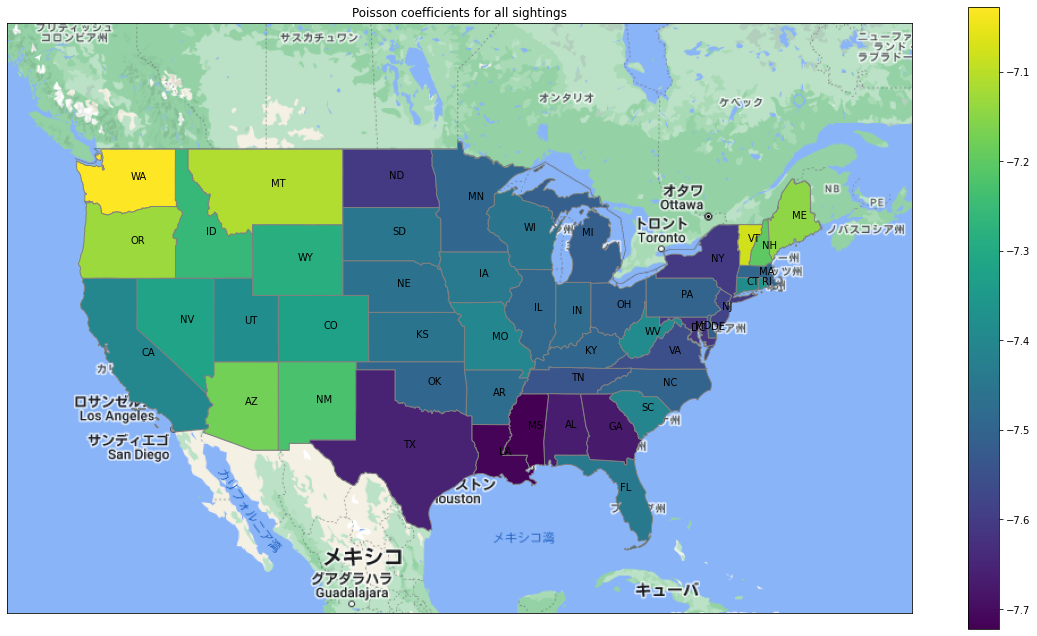

In [103]:
fig, ax = plt.subplots(figsize=(16, 9))
bounds = -130, 20, -60, 55
#bounds = tuple(geo_state.total_bounds)
draw_map(bounds, ax=ax, extent_crs="webmap", z=4, tile="google")
ax.tick_params(axis="both", which="both", bottom=False, left=False, labelleft=False, labelbottom=False)

flg1 = (geo_state.model=="all") & (geo_state.state_code != "PR")
bs = geo_state.bounds
flg2 = (bs.minx >= bounds[0]) & (bs.miny >= bounds[2]) & (bs.maxx <= bounds[1]) & (bs.maxy <= bounds[3])
tmp = geo_state[flg1 & flg2].to_crs("EPSG:3857")
tmp.plot(column="coef", edgecolor="gray", ax=ax, legend=True)

centers = tmp.centroid
for _, row in tmp.iterrows():
  cents = row.geometry.centroid
  ax.text(cents.x, cents.y, row.state_code)

ax.set_title("Poisson coefficients for all sightings")
fig.tight_layout()
None

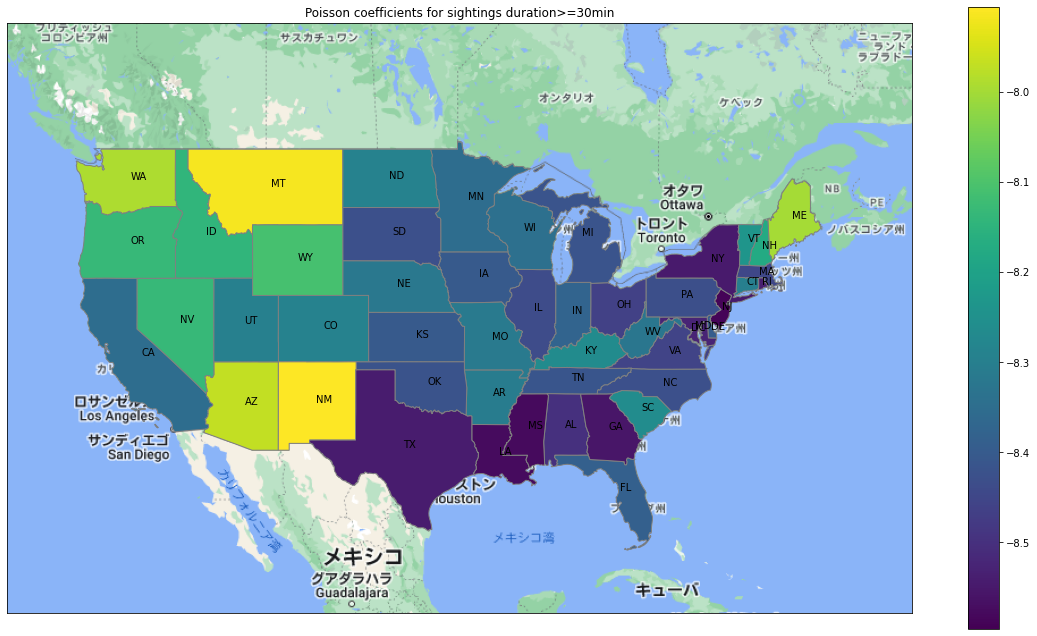

In [108]:
fig, ax = plt.subplots(figsize=(16, 9))
bounds = -130, 20, -60, 55
#bounds = tuple(geo_state.total_bounds)
draw_map(bounds, ax=ax, extent_crs="webmap", z=4, tile="google")
ax.tick_params(axis="both", which="both", bottom=False, left=False, labelleft=False, labelbottom=False)

flg1 = (geo_state.model=="30min") & (geo_state.state_code != "PR")
bs = geo_state.bounds
flg2 = (bs.minx >= bounds[0]) & (bs.miny >= bounds[2]) & (bs.maxx <= bounds[1]) & (bs.maxy <= bounds[3])
tmp = geo_state[flg1 & flg2].to_crs("EPSG:3857")
tmp.plot(column="coef", edgecolor="gray", ax=ax, legend=True)

centers = tmp.centroid
for _, row in tmp.iterrows():
  cents = row.geometry.centroid
  ax.text(cents.x, cents.y, row.state_code)

ax.set_title("Poisson coefficients for sightings duration>=30min")
fig.tight_layout()
None

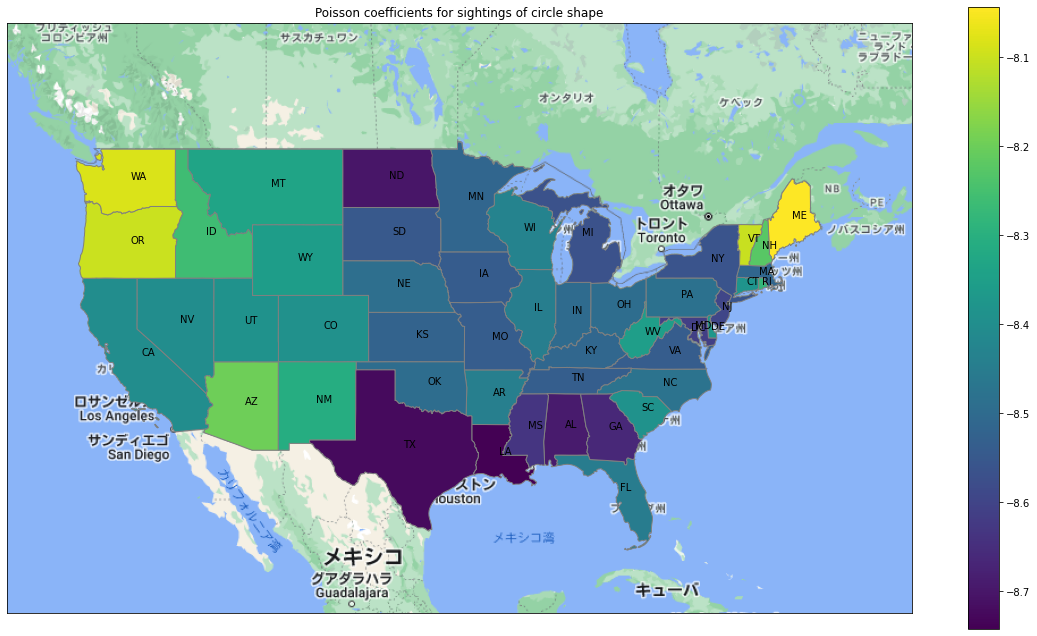

In [109]:
fig, ax = plt.subplots(figsize=(16, 9))
bounds = -130, 20, -60, 55
#bounds = tuple(geo_state.total_bounds)
draw_map(bounds, ax=ax, extent_crs="webmap", z=4, tile="google")
ax.tick_params(axis="both", which="both", bottom=False, left=False, labelleft=False, labelbottom=False)

flg1 = (geo_state.model=="circle") & (geo_state.state_code != "PR")
bs = geo_state.bounds
flg2 = (bs.minx >= bounds[0]) & (bs.miny >= bounds[2]) & (bs.maxx <= bounds[1]) & (bs.maxy <= bounds[3])
tmp = geo_state[flg1 & flg2].to_crs("EPSG:3857")
tmp.plot(column="coef", edgecolor="gray", ax=ax, legend=True)

centers = tmp.centroid
for _, row in tmp.iterrows():
  cents = row.geometry.centroid
  ax.text(cents.x, cents.y, row.state_code)

ax.set_title("Poisson coefficients for sightings of circle shape")
fig.tight_layout()
None

In [99]:
# map with counts
geo_freq = x[x.year2000p & ~x.usa.isna()].groupby("state_code", as_index=False).agg(freq=("shape", "size"))
geo_freq = pd.merge(geo_state[geo_state.model=="all"], geo_freq, on="state_code")
geo_freq["log10_freq"] = np.log10(geo_freq.freq)
geo_freq

STATEFP                                           geometry  \
0       01  POLYGON ((-87.59206 30.95146, -87.63494 30.865...   
1       02  MULTIPOLYGON (((-179.17426 51.27906, -178.9955...   
2       04  POLYGON ((-112.36504 31.74113, -113.33377 32.0...   
3       05  POLYGON ((-93.23861 33.01802, -93.37713 33.018...   
4       06  MULTIPOLYGON (((-121.90647 36.96895, -121.9516...   
5       08  POLYGON ((-106.87729 37.00014, -107.42091 37.0...   
6       09  POLYGON ((-73.54415 41.36632, -73.54331 41.375...   
7       10  POLYGON ((-75.30255 38.93900, -75.30408 38.913...   
8       11  POLYGON ((-77.11976 38.93434, -77.04102 38.995...   
9       12  MULTIPOLYGON (((-82.75938 29.00662, -82.75970 ...   
10      13  POLYGON ((-84.86346 30.71150, -84.86469 30.711...   
11      15  MULTIPOLYGON (((-155.94926 19.85703, -155.9156...   
12      16  POLYGON ((-113.00082 41.99822, -113.24916 41.9...   
13      17  POLYGON ((-90.26110 38.51826, -90.25529 38.530...   
14      18  POLYGON ((-86.92775 37.93496, -86.97774 37.925...   
15      19  POLYGON ((-94.91490 40.57492, -95.06892 40.576...   
16      20  POLYGON ((-102.04197 37.73854, -102.04425 38.1...   
17      21  POLYGON ((-89.27893 36.57770, -89.22732 36.569...   
18      22  POLYGON ((-93.70634 30.05218, -93.70394 30.054...   
19      23  MULTIPOLYGON (((-69.39329 43.95642, -69.42205 ...   
20      24  MULTIPOLYGON (((-76.40289 38.31140, -76.37448 ...   
21      25  MULTIPOLYGON (((-71.49822 42.01587, -71.55944 ...   
22      26  MULTIPOLYGON (((-86.22607 41.76002, -86.22609 ...   
23      27  POLYGON ((-95.86095 43.49999, -96.05316 43.500...   
24      28  POLYGON ((-90.25955 31.00066, -90.34601 31.000...   
25      29  POLYGON ((-94.61796 36.99891, -94.61810 37.056...   
26      30  POLYGON ((-111.43879 44.72055, -111.45695 44.6...   
27      31  POLYGON ((-101.32551 40.00257, -101.41103 40.0...   
28      32  POLYGON ((-118.50096 37.94902, -118.94967 38.2...   
29      33  POLYGON ((-72.49260 42.96765, -72.44498 43.004...   
30      34  POLYGON ((-74.91516 39.17670, -74.99800 39.191...   
31      35  POLYGON ((-109.04724 33.20890, -109.04724 33.2...   
32      36  MULTIPOLYGON (((-76.46215 41.99893, -76.47303 ...   
33      37  POLYGON ((-84.12945 34.98795, -84.32187 34.988...   
34      38  POLYGON ((-102.08755 45.94460, -102.32823 45.9...   
35      39  MULTIPOLYGON (((-83.85209 38.75143, -83.90438 ...   
36      40  POLYGON ((-98.22528 34.12724, -98.31875 34.146...   
37      41  POLYGON ((-122.50114 42.00846, -122.80008 42.0...   
38      42  POLYGON ((-78.80830 39.72307, -78.92842 39.723...   
39      44  MULTIPOLYGON (((-71.54541 41.24273, -71.53408 ...   
40      45  POLYGON ((-81.75513 33.15155, -81.76251 33.197...   
41      46  POLYGON ((-101.00043 42.99753, -101.22801 42.9...   
42      47  POLYGON ((-87.85189 35.00566, -87.98492 35.005...   
43      48  POLYGON ((-102.07365 29.78693, -102.11568 29.7...   
44      49  POLYGON ((-112.35769 37.00102, -112.53857 37.0...   
45      50  POLYGON ((-72.44056 43.21525, -72.45040 43.161...   
46      51  MULTIPOLYGON (((-82.48724 36.59582, -82.60918 ...   
47      53  MULTIPOLYGON (((-122.43867 45.56358, -122.4922...   
48      54  POLYGON ((-80.88325 37.38393, -80.83548 37.334...   
49      55  MULTIPOLYGON (((-90.64284 42.50848, -90.67273 ...   
50      56  POLYGON ((-111.04669 42.00157, -111.04708 42.3...   
51      72  MULTIPOLYGON (((-66.97870 17.95729, -66.98221 ...   

              state_name state_code state_fips  statepop2021  statepop2010  \
0                Alabama         AL         01       5039877       4779736   
1                 Alaska         AK         02        733391        710231   
2                Arizona         AZ         04       7276316       6392017   
3               Arkansas         AR         05       3011524       2915918   
4             California         CA         06      39237836      37253956   
5               Colorado         CO         08       5812069       5029196   
6          

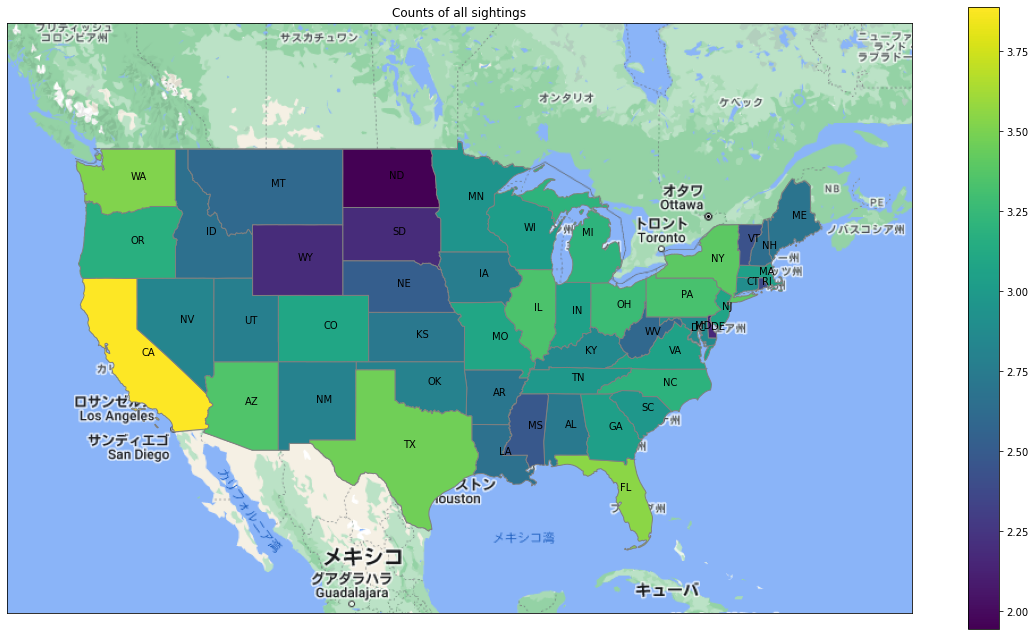

In [107]:
fig, ax = plt.subplots(figsize=(16, 9))
bounds = -130, 20, -60, 55
#bounds = tuple(geo_state.total_bounds)
draw_map(bounds, ax=ax, extent_crs="webmap", z=4, tile="google")
ax.tick_params(axis="both", which="both", bottom=False, left=False, labelleft=False, labelbottom=False)

bs = geo_freq.bounds
flg1 = (geo_freq.state_code != "PR")
flg2 = (bs.minx >= bounds[0]) & (bs.miny >= bounds[2]) & (bs.maxx <= bounds[1]) & (bs.maxy <= bounds[3])
tmp = geo_freq[flg1 & flg2].to_crs("EPSG:3857")
tmp.plot(column="log10_freq", edgecolor="gray", ax=ax, legend=True)

centers = tmp.centroid
for _, row in tmp.iterrows():
  cents = row.geometry.centroid
  ax.text(cents.x, cents.y, row.state_code)

ax.set_title("Counts of all sightings")
fig.tight_layout()
None

In [110]:
# Japan
bounds = 122, 20, 153, 45
lon, lat = 0.5*(bounds[0] + bounds[2]), 0.5*(bounds[1] + bounds[3])
m = folium.Map((lat, lon), zoom_start=5)
flg = (x.longitude >= bounds[0]) & (x.longitude <= bounds[2]) & (x.latitude >= bounds[1]) & (x.latitude <= bounds[3])
for _, row in tqdm(x[flg].iterrows()):
  if row.datetime.year >= 2000:
    color = "blue"
  else:
    color = "orange"
  icon = folium.Icon(color=color)
  folium.Marker(location=[row.latitude, row.longitude],
                popup="{} {}".format(row.comments, row.datetime),
                icon=icon).add_to(m)
m.save(os.path.join(outdir, "japan.html"))
m

72it [00:00, 2465.32it/s]
